In [455]:
import numpy as np 
import pandas as pd
from sklearn import *
from sklearn.metrics import f1_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import time
import xgboost as xgb
from catboost import Pool,CatBoostRegressor
import datetime
import gc
import os
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
import gc
import joblib
import warnings

sns.set()



sns.set_style("whitegrid")



In [456]:
path = '/home/dohee/kaggle/nims/input'
os.chdir(path)
os.listdir()

['test.csv',
 'sample_submission.csv',
 'train.csv',
 '“NIMS 풀림” 답안 제출동의서.pdf',
 'lgbm_0.sav']

In [457]:
#1만 세대의 2009-01부터 2018-05까지 사용량으로부터 2018-06부터 2019-05까지 12개월 도시가스 사용량을 예측하는 문제

In [458]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
all_cols = list(train.columns)[1:]

In [459]:
train

,id,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
0,0,26.68,11.86,19.77,14.83,7.90,2.96,5.93,4.94,4.94,4.94,6.92,19.77,31.63,19.77,23.72,13.83,11.86,11.86,5.93,4.94,3.95,5.93,5.93,17.79,14.82,35.58,26.68,16.80,9.88,5.93,4.94,1.97,4.94,6.91,6.91,17.79,25.70,32.62,18.78,21.75,9.88,6.92,4.94,3.95,5.93,6.92,5.93,3.95,0.00,25.70,33.63,14.83,7.91,7.91,6.92,6.92,3.95,3.95,5.93,15.82,32.64,38.58,29.67,16.81,10.88,3.95,4.94,4.94,4.94,5.93,14.83,19.78,23.74,25.71,33.63,11.87,8.90,3.95,3.95,6.92,2.96,5.93,8.90,12.86,26.71,35.61,31.62,11.86,6.91,3.95,2.96,1.97,2.96,1.97,6.91,10.87,5.93,3.95,3.95,5.92,4.94,4.94,4.94,0.00,0.98,2.96,6.91,7.90,6.91,0.00,8.89,9.88,7.90,3.95,0.98,1.97,0.98,2.96,4.94,6.91,9.88,0.00,2.96,7.90,4.94
1,1,107.73,77.09,79.09,4.94,48.44,22.74,33.61,23.72,23.72,25.70,48.44,86.01,117.65,77.11,39.53,46.45,48.43,22.73,17.79,23.72,23.72,52.38,14.82,41.51,123.55,134.42,84.02,40.52,24.71,23.72,15.81,12.85,12.85,15.81,17.79,21.74,58.32,76.11,39.55,30.65,33.61,18.78,17.79,6.92,12.85,17.79,20.76,43.50,78.11,73.17,26.71,22.75,26.71,18.79,13.85,6.92,6.92,13.85,10.88,87.05,58.36,80.13,51.43,26.70,19.78,17.80,10.88,8.90,4.94,14.83,11.87,18.79,31.65,22.75,39.57,20.77,19.78,14.83,11.87,7.91,6.92,8.90,10.88,19.78,44.51,62.32,47.44,30.64,20.75,19.76,6.91,6.91,8.89,14.82,21.74,40.52,41.51,88.95,79.04,39.52,29.64,16.79,16.79,11.85,8.89,19.76,19.76,54.34,113.63,118.57,88.94,54.35,37.55,26.68,20.75,11.85,11.85,19.76,22.73,38.54,145.28,56.33,62.26,58.31,32.61
2,2,94.88,90.93,78.10,66.24,38.55,25.70,27.68,26.69,18.78,15.81,45.48,67.23,70.19,49.43,36.57,29.65,32.61,13.83,17.79,12.84,11.86,18.77,66.22,98.84,179.88,213.49,98.85,85.99,89.95,44.48,28.66,35.58,25.70,61.28,76.11,136.41,242.18,257.01,169.08,154.25,62.29,35.59,28.67,20.76,13.84,37.57,76.13,112.72,258.07,174.02,138.50,131.57,70.24,11.87,31.65,19.78,10.88,24.73,64.30,112.78,159.27,190.93,187.94,126.61,92.98,0.00,0.00,0.00,0.00,0.00,127.60,3.95,137.49,19.78,66.28,49.46,49.46,9.89,1.97,11.87,4.94,0.00,47.48,47.48,78.15,64.30,68.19,49.42,36.57,13.83,1.97,6.91,0.00,19.76,26.68,28.66,27.67,58.31,57.30,30.63,25.69,13.83,13.83,5.92,9.88,13.83,26.67,71.14,175.88,137.34,88.94,233.23,92.90,13.83,0.00,0.00,0.00,0.00,0.00,81.04,130.45,71.15,0.00,0.00,0.00
3,3,0.00,0.00,149.29,51.41,6.92,8.89,2.96,2.96,1.97,3.95,4.94,5.93,20.76,21.75,20.75,9.88,4.94,1.97,2.96,2.96,0.98,3.95,3.95,3.95,9.88,4.94,8.89,3.95,3.95,2.96,1.97,1.97,1.97,1.97,2.96,2.96,16.80,11.86,5.93,5.93,3.95,5.93,4.94,5.93,6.92,15.82,19.77,51.41,88.00,110.74,67.27,65.29,30.66,23.74,20.77,14.83,7.91,10.88,13.85,61.33,74.19,64.30,78.14,57.37,50.44,41.54,26.70,19.78,13.84,0.00,0.00,0.00,0.00,156.29,64.30,52.43,63.31,9.89,0.00,14.83,2.96,7.91,23.74,82.11,79.14,122.67,103.78,98.84,13.83,9.88,8.89,5.93,2.96,8.89,20.75,18.77,25.69,119.59,95.84,75.09,25.69,13.83,17.78,7.90,9.88,16.79,61.26,119.56,195.64,220.34,199.63,145.28,55.34,38.54,0.00,0.00,0.00,5.92,26.68,74.12,158.12,159.11,105.75,86.97,43.48
4,4,97.85,97.85,70.19,60.31,31.63,25.70,20.76,22.74,20.76,20.76,34.60,76.12,125.56,103.81,85.00,67.21,75.11,25.69

In [460]:
# import copy
# tmp = copy.copy(train.iloc[:, 78-12:-12])
# tmp.columns  = train.columns[78:]
# tmp

In [461]:
# 최근 3년 선택하기
train = train.iloc[:,78:]
test = test.iloc[:,78:]

In [462]:
# 너무 큰 값 처리

# Maximum value list
max_list = test.max()
max_list

test_max = test.max()

test_max['2018-06'] = test_max['2017-06'] + 10
test_max['2018-07'] = test_max['2017-07'] + 10
test_max['2018-08'] = test_max['2017-08'] + 10
test_max['2018-09'] = test_max['2017-09'] + 10
test_max['2018-10'] = test_max['2017-10'] + 10
test_max['2018-11'] = test_max['2017-11'] + 10
test_max['2018-12'] = test_max['2017-12'] + 10
test_max['2019-01'] = test_max['2018-01'] + 10
test_max['2019-02'] = test_max['2018-02'] + 10
test_max['2019-03'] = test_max['2018-03'] + 10
test_max['2019-04'] = test_max['2018-04'] + 10
test_max['2019-05'] = test_max['2018-05'] + 10

print("before:", train.shape[0])

for i in train:
    maximum = test_max[i]
    # 최대값보다 큰 값을 없애기
    train = train[train[i]<=maximum]

print("after:", train.shape[0])
    
# for i in tmp:
#     maximum = test_max[i]
#     # 최대값보다 큰 값을 없애기
#     tmp = tmp[tmp[i]<=maximum]
    
train = train.reset_index(drop=True)
# tmp = tmp.reset_index(drop=True)

before: 78587
after: 65785


In [463]:
# from sklearn.preprocessing import StandardScaler
# train[list(test.columns)] = StandardScaler().fit_transform(train[list(test.columns)])
# # tmp[list(test.columns)] = StandardScaler().fit_transform(tmp[list(test.columns)])
# test[list(test.columns)] = StandardScaler().fit_transform(test[list(test.columns)])

In [464]:
# 2배로 만들기
# train = pd.concat([train, tmp], axis=0).reset_index(drop=True)

### 최근 3년간 2009년 1월 ~ 2019년 5월

In [465]:
jan = train.columns[[i*12-5 for i in range(1, 5)]]
feb = train.columns[[i*12-4 for i in range(1, 5)]]
mar = train.columns[[i*12-3 for i in range(1, 5)]]
apr = train.columns[[i*12-2 for i in range(1, 5)]]
may = train.columns[[i*12-1 for i in range(1, 5)]]
jun = train.columns[[i*12 for i in range(4)]]
jul = train.columns[[1+i*12 for i in range(4)]]
aug = train.columns[[2+i*12 for i in range(4)]]
sep = train.columns[[3+i*12 for i in range(4)]]
occ = train.columns[[4+i*12 for i in range(4)]]
nov = train.columns[[5+i*12 for i in range(4)]]
dec = train.columns[[i*12-6 for i in range(1, 5)]]

df_jun = train[jun].copy()
df_jul = train[jul].copy()
df_aug = train[aug].copy()
df_sep = train[sep].copy()
df_occ = train[occ].copy()
df_nov = train[nov].copy()
df_dec = train[dec].copy()
df_jan = train[jan].copy()
df_feb = train[feb].copy()
df_mar = train[mar].copy()
df_apr = train[apr].copy()
df_may = train[may].copy()

In [466]:
# # 상위 2% 이하인 것들은 2%에 해당하는 값으로 제한하기
# for i in df_jun:
#     up = np.quantile(df_jun[i], [0.98])[0]
#     df_jun[i][df_jun[i]>up]=up

In [467]:
df_jun.mean()

2015-06    18.203221
2016-06    18.037391
2017-06    16.819121
2018-06    19.417603
dtype: float64

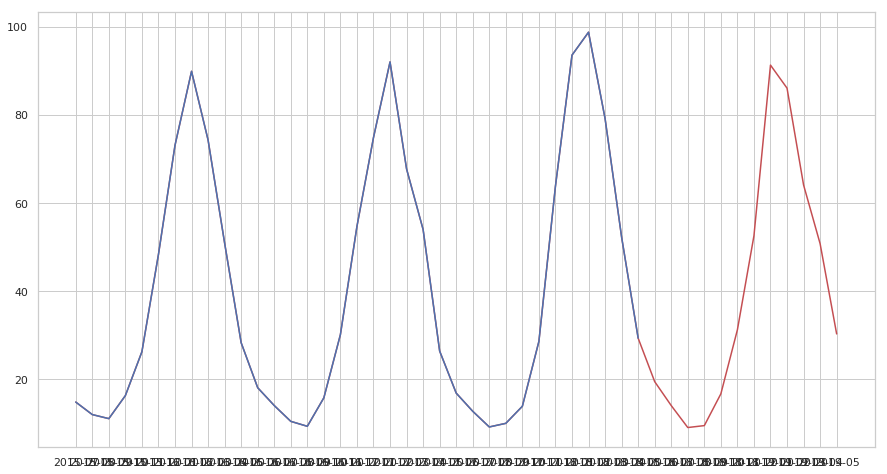

In [468]:
plt.figure(figsize=(15,8))
plt.plot(train.iloc[:,1:].mean(), c='r')
plt.plot(train.iloc[:,1:-12].mean(), c='b')

In [469]:
df_jun.values

array([[ 3.95,  3.95,  4.94,  3.95],
       [14.83, 19.76, 16.79, 26.68],
       [ 9.89, 13.83, 13.83, 13.83],
       ...,
       [ 4.94,  4.94,  5.92,  4.94],
       [28.68, 26.68, 27.66, 11.85],
       [37.59, 27.67, 28.65, 29.64]])

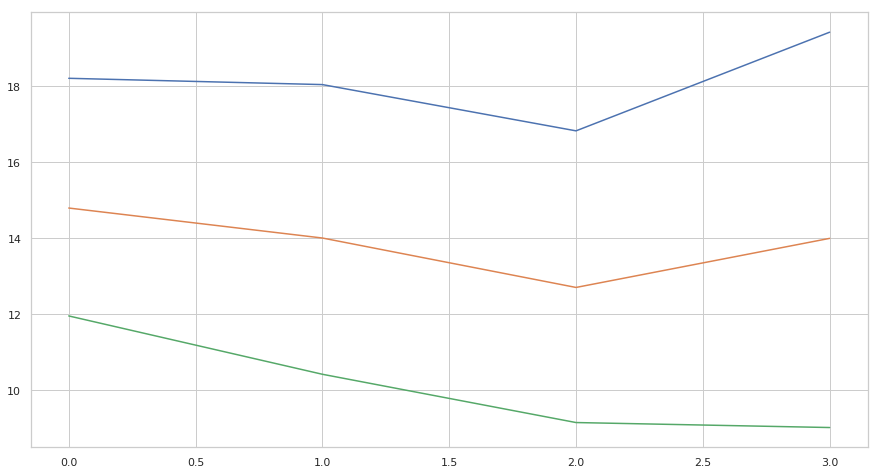

In [470]:
plt.figure(figsize=(15,8))
plt.plot(df_jun.values.mean(axis=0))
plt.plot(df_jul.values.mean(axis=0))
plt.plot(df_aug.values.mean(axis=0))

In [471]:
df_jun.mean()

2015-06    18.203221
2016-06    18.037391
2017-06    16.819121
2018-06    19.417603
dtype: float64

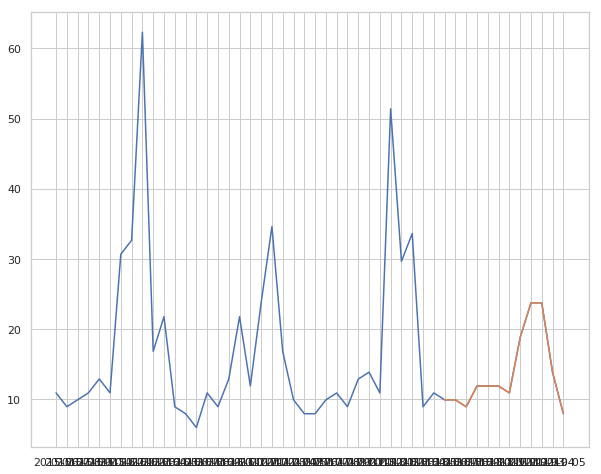

In [472]:
row = 289
plt.figure(figsize=(10,8))
plt.plot(train.iloc[row,:])
plt.plot(train.iloc[row,-12:])
plt.show()

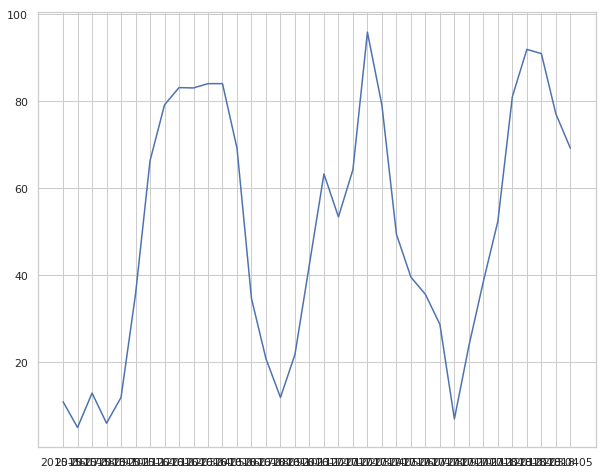

In [473]:
row = 12
plt.figure(figsize=(10,8))
plt.plot(test.iloc[row,:])
plt.show()

지지지난해 같은 달의 값 <br/>
지지난해 같은 달의 값 <br/>
지난해 같은 달의 값 <br/>
지난해 근방(3,5,7개월)의 평균 <br/>
지지난해 근방(3개월)의 평균
지지지난해 근방(3개월)의 평균

최근 3년의 평균 <br/>
지난해의 분산 <br/>
지지난해의 분산 <br/>
지지지난해의 분산 <br/>
지난해 0의 count <br/>

In [474]:
# 사용량이 있다가 계량기 고장으로 0으로 떨어지는 경우
# 거주지 이전으로 인해 사용량이 0인 경우
# 고객이 사용량을 전화나 문자로 알려줄 때 사용량을 속여 매월 일정한 값을 제공하는 경우
# 도시가스 용도가 잘못 기재되어 월별 사용량이 비정상적으로 큰 경우

In [475]:
#def f1_score_calc(y_true, y_pred):
#    return f1_score(y_true, y_pred, average="macro")

from sklearn.metrics import mean_squared_error
folds = KFold(n_splits=5, shuffle=True, random_state=123)


def train_model_classification(X, X_test, y, params, model_type='lgb', eval_metric='rmse',
                               columns=None, plot_feature_importance=True, model=None,
                               verbose=200, early_stopping_rounds=200, n_estimators=2000):

    columns = [col for col in list(X.columns) if col!='target'] # if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    #metrics_dict = {
    #                'f1score': {'lgb_metric_name': lgb_Metric,}
    #               }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X) )
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test)))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        #if True:        
        #    X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=7)    

        if model_type == 'lgb':

            model = lgb.LGBMRegressor(**params)
            model.fit(X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    eval_metric='rmse',
                    early_stopping_rounds=early_stopping_rounds)

            #model = lgb.train(params, lgb.Dataset(X_train, y_train),
            #                  n_estimators,  lgb.Dataset(X_valid, y_valid),
            #                  verbose_eval=verbose, early_stopping_rounds=early_stopping_rounds)

            preds = model.predict(X_valid, num_iteration=model.best_iteration_) #model.predict(X_valid) 
            y_pred_valid = preds
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            y_pred = y_pred


        if model_type == 'xgb':
            train_set = xgb.DMatrix(X_train, y_train)
            val_set = xgb.DMatrix(X_valid, y_valid)
            model = xgb.train(params, train_set, num_boost_round=2222, evals=[(train_set, 'train'), (val_set, 'val')], 
                                     verbose_eval=verbose, early_stopping_rounds=early_stopping_rounds)

            preds = model.predict(xgb.DMatrix(X_valid)) #model.predict(X_valid) 
            y_pred_valid = preds#np.round(np.clip(preds, 0, 10)).astype(int)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_pred = y_pred#np.round(np.clip(y_pred, 0, 10)).astype(int)


#             preds = model.predict(xgb.DMatrix(X)) 
#             y_pred = model.predict(xgb.DMatrix(X_test))


        if model_type == 'cat':
            # Initialize CatBoostRegressor
            model = CatBoostRegressor(params)
            # Fit model
            model.fit(X_train, y_train)
            # Get predictions
            y_pred_valid = preds#np.round(np.clip(preds, 0, 10)).astype(int)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_pred = y_pred#np.round(np.clip(y_pred, 0, 10)).astype(int)


        oof = preds

        scores.append(mean_squared_error(y_valid, y_pred_valid )**0.5 )
        prediction += y_pred    

        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('FINAL score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['model'] = model
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [476]:
#Let's uses 'singal_undrifted' instead of 'signal'
#cols_to_remove = []

TRAINING = True
MODEL_TYPE = 'lgb'

if TRAINING and MODEL_TYPE == 'lgb':
    params = {'learning_rate': 0.1, 
              'max_depth': 7, 
              "boosting": "gbdt",
              'num_leaves':2**7+1, 
              'metric': 'rmse', 
              'random_state': 7, 
              'reg_lambda': 0.5,
              'n_jobs':-1,
              'verbose':-1}
    
    
    
#     params = {'num_leaves': 4,
#       'min_data_in_leaf': 5,
#       'objective':'fair',
#       'max_depth': -1,
#       'learning_rate': 0.02,
#       "boosting": "gbdt",
#       'boost_from_average': True,
#       "feature_fraction": 0.9,
#       "bagging_freq": 1,
#       "bagging_fraction": 0.5,
#       "bagging_seed": 0,
#       "metric": 'mae',
#       "verbosity": -1,
#       'max_bin': 500,
#       'reg_alpha': 0,
#       'reg_lambda': 0,
#       'seed': 0,
#       'n_jobs': 1
#       }

#     params = {
#         'boosting_type': 'gbdt',
#         'objective': 'poisson',
#         'metric': 'rmse',
#         'learning_rate': 0.01,
#         'num_leaves':255,
#         'max_depth': 8,  
#         'min_child_samples': 100,  
#         'max_bin': 100,  
#         'subsample': 0.7,  
#         'subsample_freq': 1,  
#         'colsample_bytree': 0.7,  
#         'min_child_weight': 0,  
#         'subsample_for_bin': 200000,  
#         'min_split_gain': 0,  
#         'reg_alpha': 0,  
#         'reg_lambda': 0,  
#        # 'nthread': 8,
#         'verbose': 200,
#         'scale_pos_weight':99 

In [477]:
train

,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
0,3.95,3.95,6.92,2.96,5.93,8.90,12.86,26.71,35.61,31.62,11.86,6.91,3.95,2.96,1.97,2.96,1.97,6.91,10.87,5.93,3.95,3.95,5.92,4.94,4.94,4.94,0.00,0.98,2.96,6.91,7.90,6.91,0.00,8.89,9.88,7.90,3.95,0.98,1.97,0.98,2.96,4.94,6.91,9.88,0.00,2.96,7.90,4.94
1,14.83,11.87,7.91,6.92,8.90,10.88,19.78,44.51,62.32,47.44,30.64,20.75,19.76,6.91,6.91,8.89,14.82,21.74,40.52,41.51,88.95,79.04,39.52,29.64,16.79,16.79,11.85,8.89,19.76,19.76,54.34,113.63,118.57,88.94,54.35,37.55,26.68,20.75,11.85,11.85,19.76,22.73,38.54,145.28,56.33,62.26,58.31,32.61
2,9.89,1.97,11.87,4.94,0.00,47.48,47.48,78.15,64.30,68.19,49.42,36.57,13.83,1.97,6.91,0.00,19.76,26.68,28.66,27.67,58.31,57.30,30.63,25.69,13.83,13.83,5.92,9.88,13.83,26.67,71.14,175.88,137.34,88.94,233.23,92.90,13.83,0.00,0.00,0.00,0.00,0.00,81.04,130.45,71.15,0.00,0.00,0.00
3,9.89,0.00,14.83,2.96,7.91,23.74,82.11,79.14,122.67,103.78,98.84,13.83,9.88,8.89,5.93,2.96,8.89,20.75,18.77,25.69,119.59,95.84,75.09,25.69,13.83,17.78,7.90,9.88,16.79,61.26,119.56,195.64,220.34,199.63,145.28,55.34,38.54,0.00,0.00,0.00,5.92,26.68,74.12,158.12,159.11,105.75,86.97,43.48
4,5.93,5.93,4.94,3.95,5.93,4.94,7.91,15.82,34.62,13.83,9.88,11.86,7.90,4.94,4.94,2.96,1.97,15.81,38.54,5.93,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,29.64,29.64,25.69,29.64,19.76,18.77,14.82,13.83,8.89,8.89,16.80,22.73,20.75,26.68,32.61,19.76,21.74,15.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65780,31.65,12.86,11.87,12.86,15.82,19.78,48.47,72.21,85.07,53.37,29.65,20.75,14.82,11.86,9.88,9.88,10.87,17.79,43.48,63.25,95.87,50.39,36.55,27.66,18.77,12.84,10.86,13.83,16.79,24.70,75.09,126.47,98.81,56.33,37.55,28.66,27.67,18.77,9.88,12.84,29.64,38.54,57.32,92.90,81.04,70.17,56.33,39.53
65781,26.71,26.71,8.90,19.78,21.76,27.70,37.59,54.41,43.52,77.09,41.51,19.76,25.69,24.71,22.73,19.76,22.73,27.67,37.55,45.46,53.37,41.50,30.63,32.60,25.69,22.72,17.78,13.83,20.75,23.71,45.45,46.44,53.35,58.30,31.62,29.64,27.67,24.70,19.76,20.75,23.71,33.60,60.28,46.45,53.36,36.57,44.47,29.65
65782,4.94,6.92,6.92,6.92,7.91,0.98,13.85,21.76,44.51,24.71,15.81,5.93,4.94,7.90,2.96,7.90,4.94,8.89,29.65,23.72,42.50,16.79,14.82,5.92,5.92,7.90,4.94,5.92,6.91,9.88,24.70,23.71,45.45,8.89,9.88,3.95,4.94,5.92,4.94,3.95,5.92,6.91,6.91,18.77,22.73,17.79,9.88,6.91
65783,28.68,26.71,17.80,17.80,27.70,46.49,84.09,85.07,113.76,95.87,54.36,37.55,26.68,18.77,12.84,17.79,30.64,63.25,74.13,80.06,118.60,74.10,70.15,34.58,27.66,16.79,16.79,19.76,28.65,56.32,72.13,112.64,107.70,85.98,67.20,42.49,11.85,29.64,10.87,12.84,21.74,61.27,83.01,184.81,156.15,100.81,91.92,39.53


In [478]:
# windows = [3,5]

# #windows = [3,5,7,9,11]


# rolling_mean_dict = {}
# rolling_std_dict = {}
# rolling_var_dict = {}
# rolling_min_dict = {}
# rolling_max_dict = {}
# rolling_ratio_dict = {}
# rolling_diff_dict = {}

# # rolling_mean_dict2 = {}
# # rolling_std_dict2 = {}
# # rolling_var_dict2 = {}
# # rolling_min_dict2 = {}
# # rolling_max_dict2 = {}
# # rolling_ratio_dict2 = {}
# # rolling_diff_dict2 = {}

# for window in windows:
#     rolling_mean = train.rolling(window=window, min_periods=1, axis=1, center=True).median()
#     rolling_std = train.rolling(window=window, min_periods=1, axis=1, center=True).std()
#     rolling_var = train.rolling(window=window, min_periods=1, axis=1, center=True).var()
#     rolling_min = train.rolling(window=window, min_periods=1, axis=1, center=True).min()
#     rolling_max = train.rolling(window=window, min_periods=1, axis=1, center=True).max()
#     rolling_ratio = rolling_min / rolling_max
#     rolling_diff = rolling_max - rolling_min

#     rolling_mean_dict[window] = rolling_mean
#     rolling_std_dict[window] = rolling_std
#     rolling_var_dict[window] = rolling_var
#     rolling_min_dict[window] = rolling_min
#     rolling_max_dict[window] = rolling_max
#     rolling_ratio_dict[window] = rolling_ratio
#     rolling_diff_dict[window] = rolling_diff
    
# #     rolling_mean2 = train.rolling(window=window, min_periods=1, axis=1, center=False).mean()
# #     rolling_std2 = train.rolling(window=window, min_periods=1, axis=1, center=False).std()
# #     rolling_var2 = train.rolling(window=window, min_periods=1, axis=1, center=False).var()
# #     rolling_min2 = train.rolling(window=window, min_periods=1, axis=1, center=False).min()
# #     rolling_max2 = train.rolling(window=window, min_periods=1, axis=1, center=False).max()
# #     rolling_ratio2 = rolling_min2 / rolling_max2
# #     rolling_diff2 = rolling_max2 - rolling_min2

# #     rolling_mean_dict2[window] = rolling_mean2
# #     rolling_std_dict2[window] = rolling_std2
# #     rolling_var_dict2[window] = rolling_var2
# #     rolling_min_dict2[window] = rolling_min2
# #     rolling_max_dict2[window] = rolling_max2
# #     rolling_ratio_dict2[window] = rolling_ratio2
# #     rolling_diff_dict2[window] = rolling_diff2
    


In [479]:
train_ori = pd.read_csv('train.csv')


In [487]:
def fe(idx, train, existing_columns, columns, columns_rolling , istest=False): #, istest=False
    
    # create dataframe
    df = pd.DataFrame()
    
    print("month:", all_cols[77:][idx])
    print("columns_rolling")
    print(columns_rolling)
    
    for elem in [col for col in columns if col in existing_columns]:
        df[elem] = train[elem]
    
    print("not exists:", [col for col in columns if col not in existing_columns])
        
    for window in windows:
        for col in columns_rolling:
            df["rolling_mean_" + col +'_' + str(window) ] = rolling_mean_dict[window][col]
            df["rolling_std_" + col +'_'+ str(window)] = rolling_std_dict[window][col]
            df["rolling_min_" + col +'_'+ str(window)] = rolling_min_dict[window][col]
            df["rolling_max_" + col +'_'+ str(window)] = rolling_max_dict[window][col]
        df["rolling_mean_diff" +'_' + str(window)] = df["rolling_mean_" + columns_rolling[0] +'_' + str(window)] - df["rolling_mean_" + columns_rolling[1] +'_' + str(window) ]
            
            #df["rolling_ratio_" + col +'_'+ str(window)] = rolling_ratio_dict[window][col]
            #df["rolling_var_" + col +'_'+ str(window)] = rolling_var_dict[window][col]        

#     # 연간 통계
#     for window in windows:
#         for col in columns_rolling:
#             df["rolling_mean_" + col +'_' + str(window) ] = rolling_mean_dict[window][col]
#             df["rolling_std_" + col +'_'+ str(window)] = rolling_std_dict[window][col]
#             df["rolling_min_" + col +'_'+ str(window)] = rolling_min_dict[window][col]
#             df["rolling_max_" + col +'_'+ str(window)] = rolling_max_dict[window][col]
            
            
#             df["rolling_mean2_" + col +'_' + str(window) ] = rolling_mean_dict2[window][col]
#             df["rolling_std2_" + col +'_'+ str(window)] = rolling_std_dict2[window][col]
#             df["rolling_min2_" + col +'_'+ str(window)] = rolling_min_dict2[window][col]
#             df["rolling_max2_" + col +'_'+ str(window)] = rolling_max_dict2[window][col]

    # 최근 6개월 소비
    #for col in all_cols[-18:-12]:
    
    assert columns_rolling[0] == all_cols[77:][idx-12]
    
    # 3년간 통계
    df['yearly_mean'] = train[columns_rolling].median(axis=1)
    df['yearly_std'] = train[columns_rolling].std(axis=1)
    df['yearly_max'] = train[columns_rolling].max(axis=1)
    df['yearly_min'] = train[columns_rolling].min(axis=1)
    df['yearly_max_min'] = df['yearly_max'] - df['yearly_min']
    df['yearly_diff1'] = df[columns_rolling[0]] - df[columns_rolling[1]]
    #df['yearly_diff2'] = df[columns_rolling[0]] - df[columns_rolling[2]]
        
    
    # 최근 6개월 통계
    col_tmp = list(train.columns) 
    df['recent_mean_6'] = train[all_cols[-18:-12]].median(axis=1)
    df['recent_mean_6_80'] = train[all_cols[-18:-12]].quantile(0.8, axis=1)
    df['recent_mean_6_20'] = train[all_cols[-18:-12]].quantile(0.2, axis=1)
    
    
    df['recent_mean_3'] = train[all_cols[-15:-12]].median(axis=1)
    df['recent_mean_3_80'] = train[all_cols[-15:-12]].quantile(0.8, axis=1)
    df['recent_mean_3_20'] = train[all_cols[-15:-12]].quantile(0.2, axis=1)
    
    df['recent_mean_2'] = train[all_cols[-14:-12]].median(axis=1)    
    df['recent_mean_2_80'] = train[all_cols[-14:-12]].quantile(0.8, axis=1)
    df['recent_mean_2_20'] = train[all_cols[-14:-12]].quantile(0.2, axis=1)
    
    df['recent_std_6'] = train[all_cols[-18:-12]].std(axis=1)
    df['recent_std_3'] = train[all_cols[-15:-12]].std(axis=1)
    df['recent_std_2'] = train[all_cols[-14:-12]].std(axis=1)

    
    if all_cols[-13] not in col_tmp:
        df['recent_1'] = train[all_cols[-13]]

    if all_cols[-14] not in col_tmp:
        df['recent_2'] = train[all_cols[-14]]

    if all_cols[-15] not in col_tmp:
        df['recent_3'] = train[all_cols[-15]]

        
    df['recent_std_6'] = train[all_cols[-18:-12]].std(axis=1)
    df['recent_std_3'] = train[all_cols[-15:-12]].std(axis=1)
    #df['recent_std_2'] = train[all_cols[-14:-12]].std(axis=1)
    df['recent_diff1'] = train[all_cols[-13]] - train[all_cols[-14]]
    df['recent_diff2'] = train[all_cols[-13]] - train[all_cols[-15]]
    df['recent_diff3'] = train[all_cols[-13]] - train[all_cols[-16]]
    
    if istest==False:
        print("최근 2년:", all_cols[-36:-12])
        print("최근 6개월:", all_cols[-18:-12])
        
        # 지난 2년간 0의 count
        df['zero_count'] = (train[all_cols[-36:-12]]==0).sum(axis=1)

        # 최근 0의 count
        df['zero_count_recent'] = (train[all_cols[-18:-12]]==0).sum(axis=1)

    else:
        
        print("최근 2년:", all_cols[-36:-12])
        print("최근 6개월:", all_cols[-18:-12])
        
        # 지난 2년간 0의 count
        df['zero_count'] = (train[all_cols[-36:-12]]==0).sum(axis=1)

        # 최근 0의 count
        df['zero_count_recent'] = (train[all_cols[-18:-12]]==0).sum(axis=1)

    # target
    if istest==False:
        df['target'] = train[all_cols[77:][idx]]
        
    index_list = []
    if istest==False:
        df = df[df['zero_count_recent']<=1]
        df = df[df['zero_count']<=3]
        #df = df[(train[['2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']]==0).sum(axis=1)<=6]
        
        #df.loc[df['zero_count_recent']>=1,'target'] = 0
        #df.loc[df['zero_count']>=2,'target'] = 0

        #df.loc[df['zero_count_recent']==1,'target'] /= 2
        #df.loc[df['zero_count']==2,'target'] /= 2
        
        #print(df.loc[df['zero_count']>3,'target'])
        
        #df[~((train['2019-01']==0) & (train['2019-02']==0))]
        index_list = list(df.index)
        df = df.reset_index(drop=True)
        
        
    else:
        pass
        #df[df['zero_count']>=3] = 3
        #df[df['zero_count_recent']>=1] = 1

    #df[[elem for elem in list(df.columns) if elem!='target']] = MinMaxScaler().fit_transform(df[[elem for elem in list(df.columns) if elem!='target']])    
        
    return df, index_list

In [488]:
# train[train['2019-01']==0][['2017-01','2018-01','2018-03','2018-04','2018-05','2018-12','2019-01','2019-02']]

In [489]:
# train[train['2018-01']==0][['2017-01','2018-01','2018-01','2018-02','2018-03','2018-04','2018-05']]

In [490]:
# list(train_df[train_df['2018-05']==0][['2016-05','2017-05','2018-05']].index)

In [491]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#train[list(test.columns)] = StandardScaler().fit_transform(train[list(test.columns)])
# tmp[list(test.columns)] = StandardScaler().fit_transform(tmp[list(test.columns)])
#test[list(test.columns)] = StandardScaler().fit_transform(test[list(test.columns)])




0it [00:00, ?it/s]

month: 2018-06
month: 2018-06
columns_rolling
['2017-06', '2016-06']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
month: 2018-06
columns_rolling
['2017-06', '2016-06']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
Fold 1 started at Fri Apr 10 11:46:03 2020
[1]	valid_0's rmse: 14.5293
Training until validation scores don't improve for 150 rounds
[2]	valid_0's rmse: 




1it [00:04,  4.25s/it]

month: 2018-07
month: 2018-07
columns_rolling
['2017-07', '2016-07']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
month: 2018-07
columns_rolling
['2017-07', '2016-07']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
Fold 1 started at Fri Apr 10 11:46:08 2020
[1]	valid_0's rmse: 11.2235
Training until validation scores don't improve for 150 rounds
[2]	valid_0's rmse: 




2it [00:08,  4.33s/it]

month: 2018-08
month: 2018-08
columns_rolling
['2017-08', '2016-08']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
month: 2018-08
columns_rolling
['2017-08', '2016-08']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
Fold 1 started at Fri Apr 10 11:46:12 2020
[1]	valid_0's rmse: 8.75734
Training until validation scores don't improve for 150 rounds
[2]	valid_0's rmse: 




3it [00:12,  4.27s/it]

month: 2018-09
month: 2018-09
columns_rolling
['2017-09', '2016-09']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
month: 2018-09
columns_rolling
['2017-09', '2016-09']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
Fold 1 started at Fri Apr 10 11:46:16 2020
[1]	valid_0's rmse: 8.95344
Training until validation scores don't improve for 150 rounds
[2]	valid_0's rmse: 




4it [00:16,  4.20s/it]

month: 2018-10
month: 2018-10
columns_rolling
['2017-10', '2016-10']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
month: 2018-10
columns_rolling
['2017-10', '2016-10']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
Fold 1 started at Fri Apr 10 11:46:20 2020
[1]	valid_0's rmse: 13.321
Training until validation scores don't improve for 150 rounds
[2]	valid_0's rmse: 1




5it [00:21,  4.23s/it]

month: 2018-11
month: 2018-11
columns_rolling
['2017-11', '2016-11']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
month: 2018-11
columns_rolling
['2017-11', '2016-11']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
Fold 1 started at Fri Apr 10 11:46:25 2020
[1]	valid_0's rmse: 26.5071
Training until validation scores don't improve for 150 rounds
[2]	valid_0's rmse: 




6it [00:25,  4.25s/it]

month: 2018-12
month: 2018-12
columns_rolling
['2017-12', '2016-12']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
month: 2018-12
columns_rolling
['2017-12', '2016-12']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
Fold 1 started at Fri Apr 10 11:46:29 2020
[1]	valid_0's rmse: 40.6704
Training until validation scores don't improve for 150 rounds
[2]	valid_0's rmse: 




7it [00:29,  4.29s/it]

month: 2019-01
month: 2019-01
columns_rolling
['2018-01', '2017-01']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
month: 2019-01
columns_rolling
['2018-01', '2017-01']
not exists: []
최근 2년: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
최근 6개월: ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05']
Fold 1 started at Fri Apr 10 11:46:33 2020
[1]	valid_0's rmse: 60.4354
Training until validation scores don't improve for 150 rounds
[2]	valid_0's rmse: 




8it [00:34,  4.33s/it]



--------------------
[9.561424210360055, 7.892118044744484, 6.658587039153151, 6.858368577075746, 9.889808957423707, 18.75100673678964, 27.540012979293166, 39.43931124845537]
score: 15.823829724161914


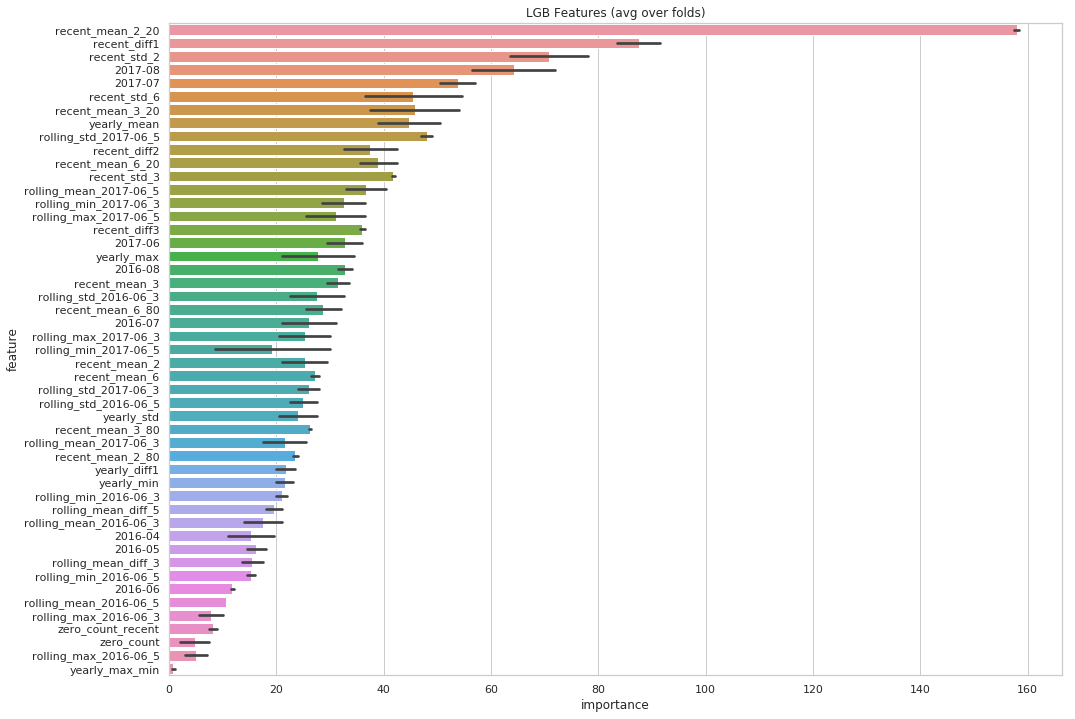

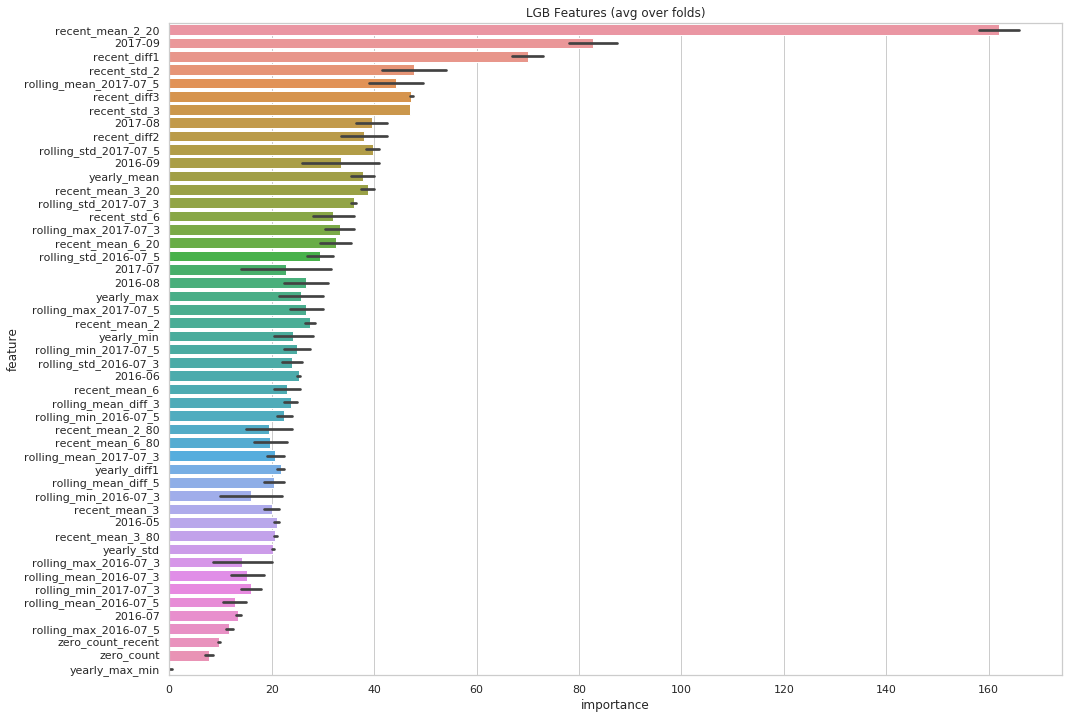

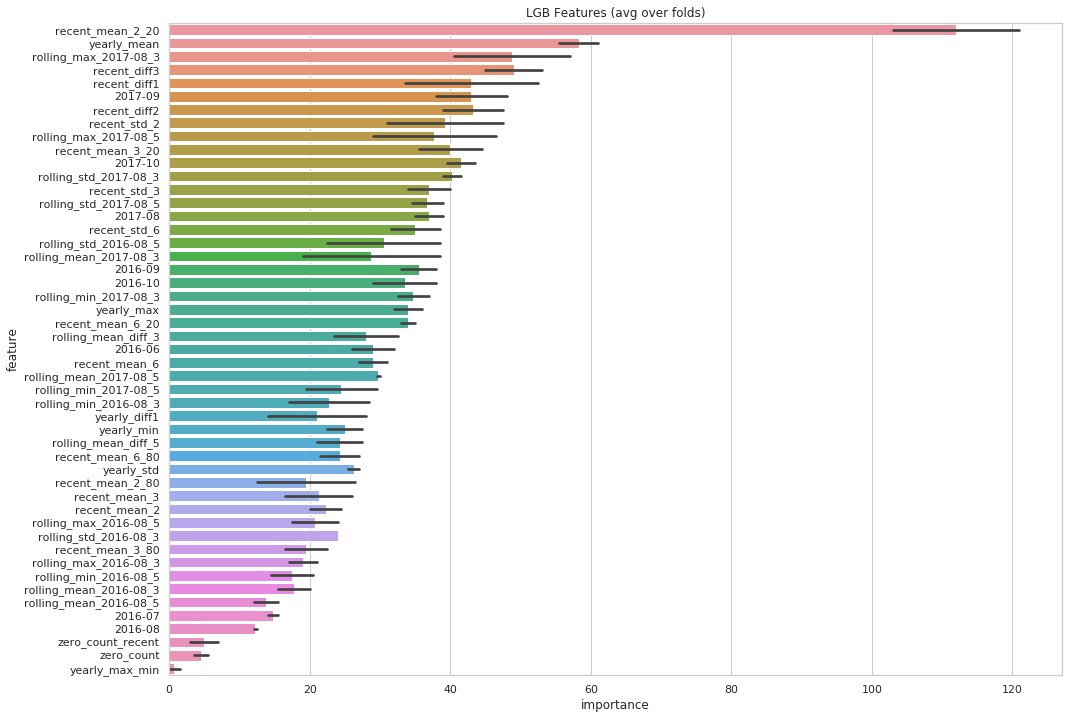

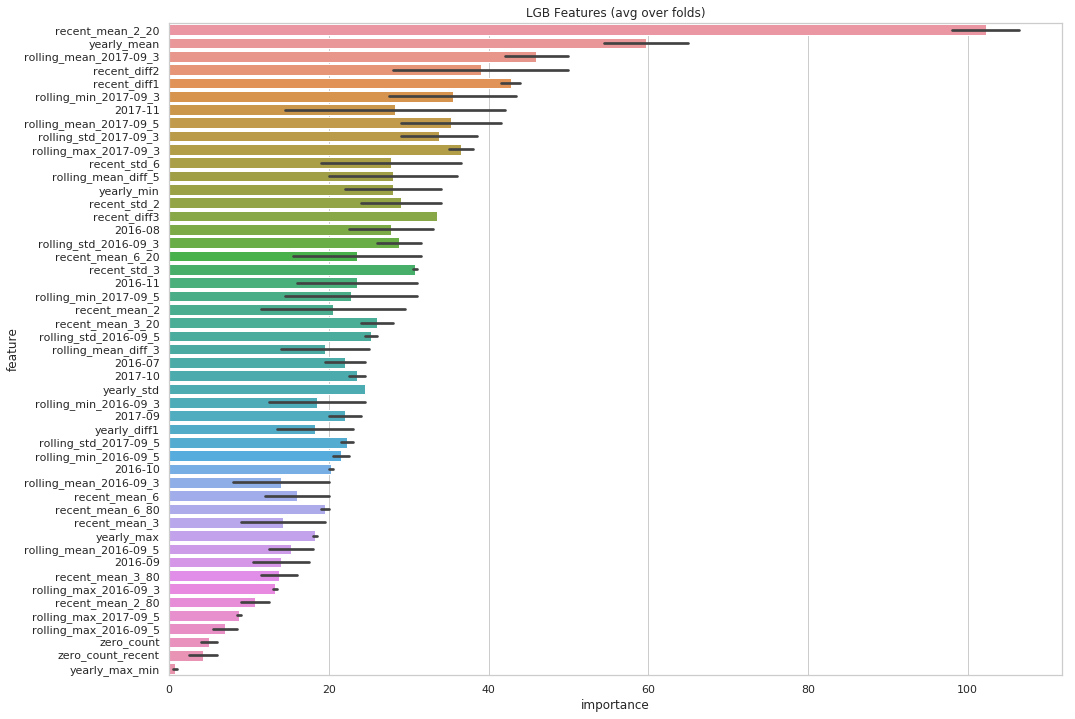

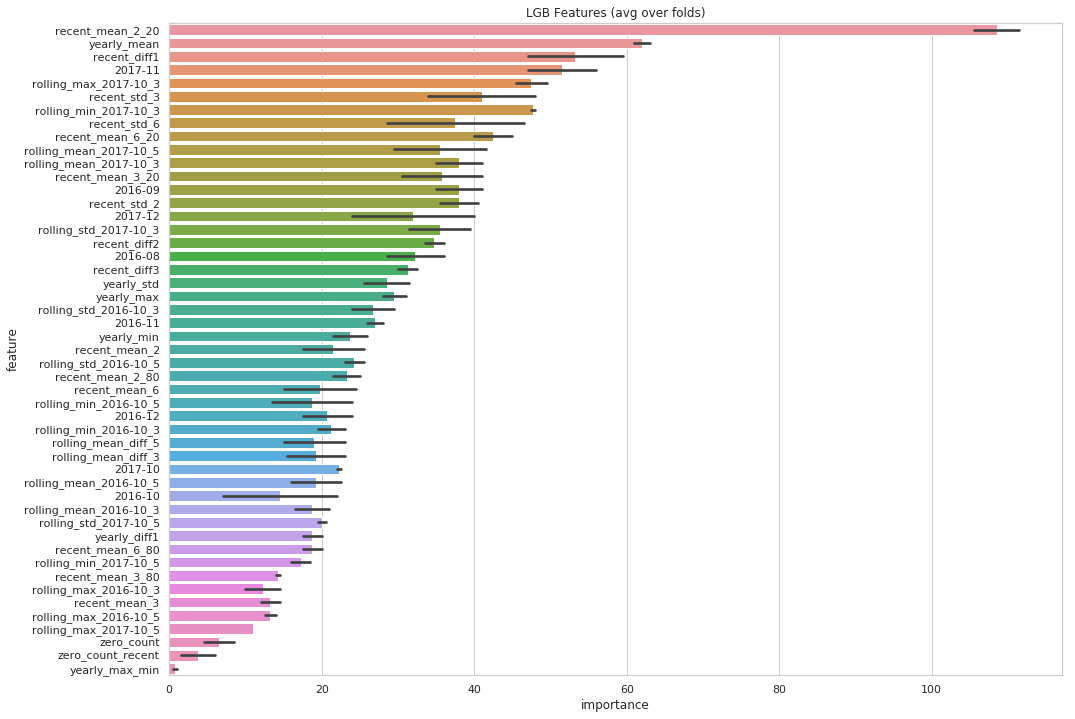

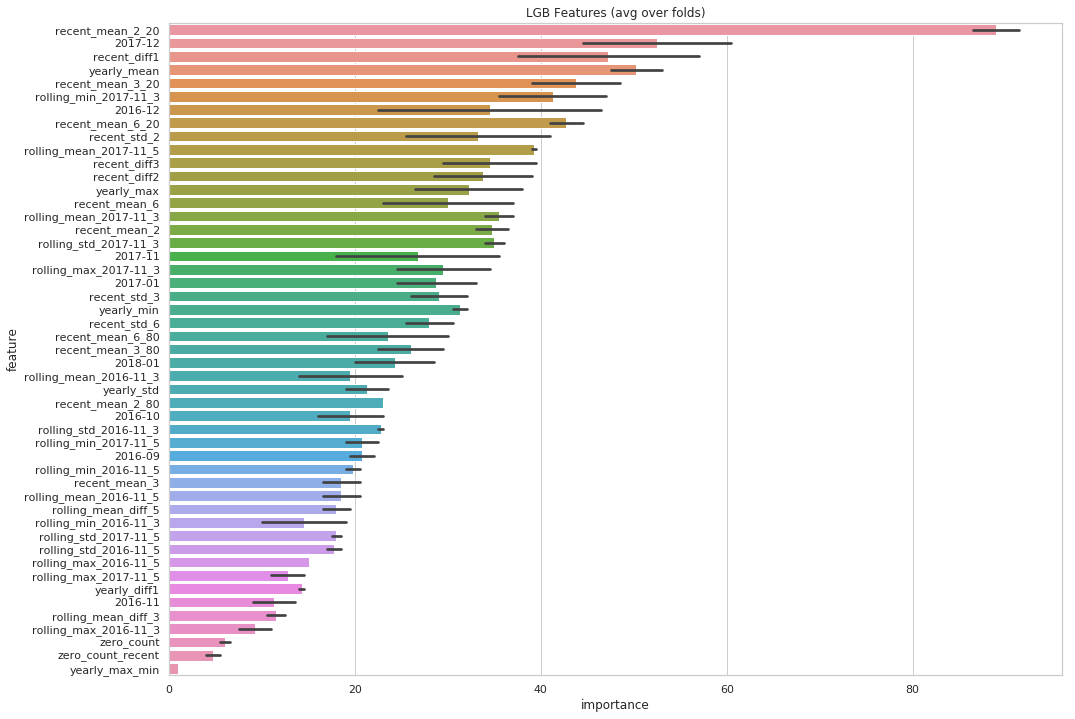

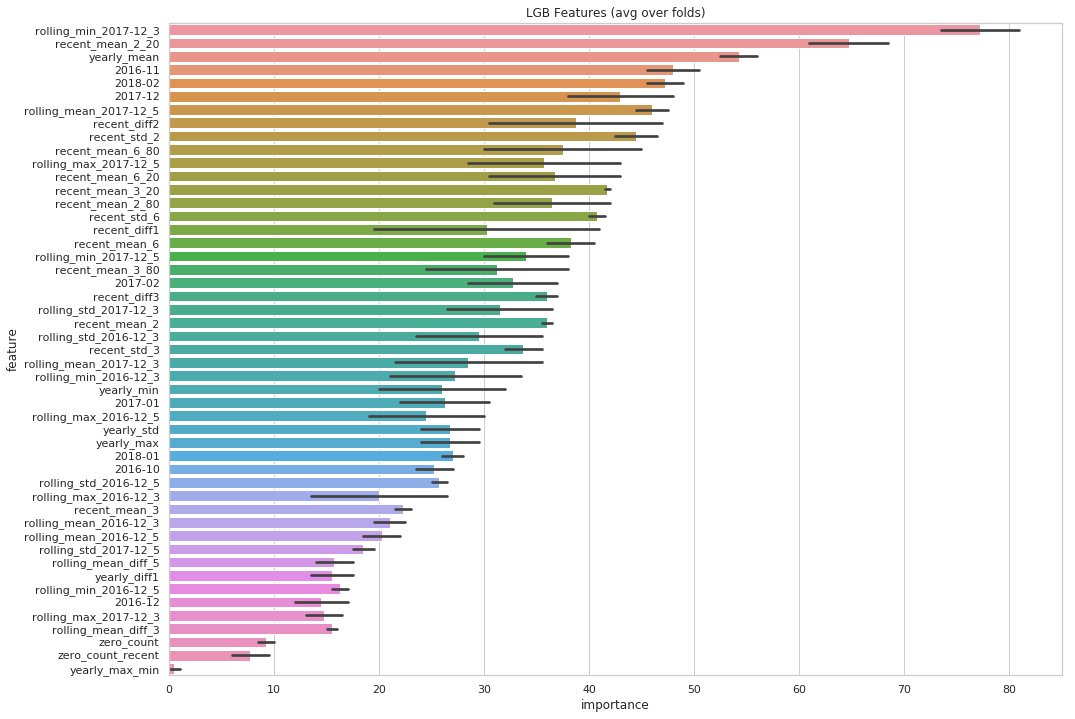

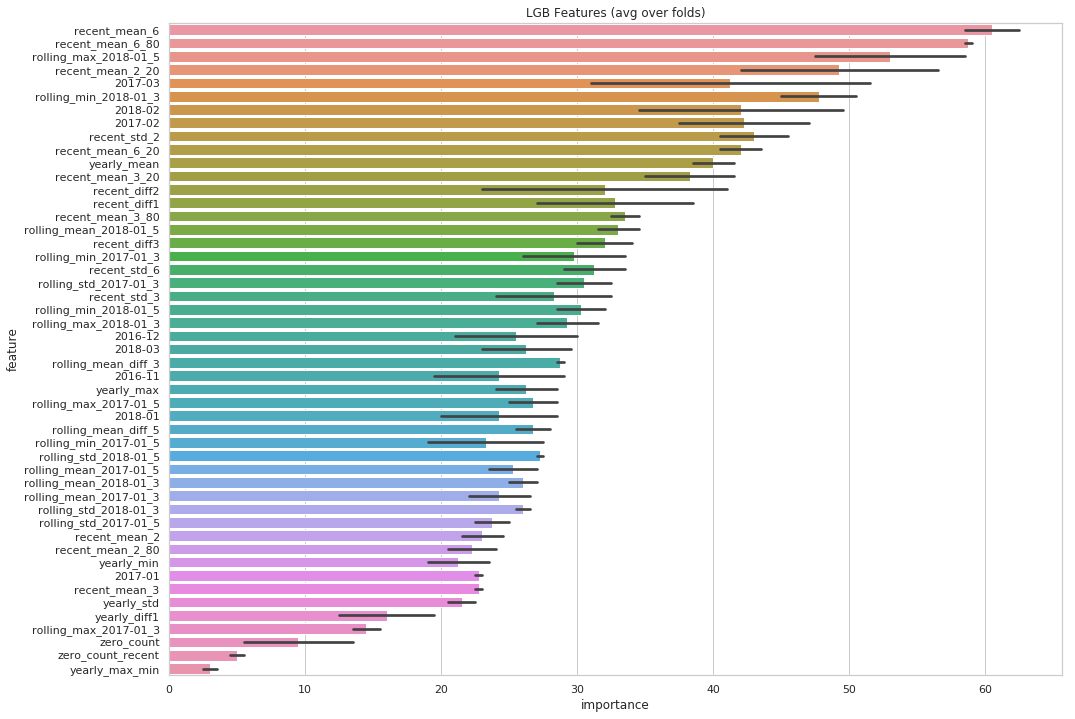

In [492]:
from tqdm import tqdm

sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

folds = KFold(n_splits=2, shuffle=True, random_state=7)
score_list = []

#from sklearn.preprocessing import StandardScaler
#train[list(test.columns)] = StandardScaler().fit_transform(train[list(test.columns)])
#test[list(test.columns)] = StandardScaler().fit_transform(test[list(test.columns)])

test_columns = list(sample_submission.columns[1:])
for idx, month in tqdm(enumerate(test_columns[:-4])): 
    
    print("month:", month)
    
    
    #to_add = [all_cols[idx-i] for i in [23,24,25,35,36,37,47,48,49]]
    #to_add = [elem for elem in to_add if elem in test.columns]
    
    columns = [all_cols[idx-22], all_cols[idx-23], all_cols[idx-24], all_cols[idx-23], all_cols[idx-22], 
               all_cols[idx-38], all_cols[idx-37], all_cols[idx-36], all_cols[idx-35], all_cols[idx-34],]
               #all_cols[idx-50], all_cols[idx-49], all_cols[idx-48], all_cols[idx-47], all_cols[idx-46]]
    columns_rolling = [all_cols[idx-24], all_cols[idx-36]]#, all_cols[idx-48]]
    
    train_df, index_list = fe(36+idx, train, list(test.columns), columns, columns_rolling)
    test_df, _ = fe(36+idx, test, list(test.columns), columns, columns_rolling, True)
    
    if TRAINING: 
        cols = [c for c in train_df.columns if c not in ['target']]
        X = train_df[cols]
        y = train_df['target']
    
    X_test = test_df[cols]
    
    result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, model_type=MODEL_TYPE, eval_metric='rmse', plot_feature_importance=True,
                                                          early_stopping_rounds=150)
    score_list.append(np.mean(result_dict_lgb['scores']))
    sample_submission[month] = result_dict_lgb['prediction']

print()
print("--------------------")
print(score_list)
print("score:", np.mean(score_list))

In [493]:
[9.573002497836292,
 7.892065242124982,
 6.667031888588962,
 6.856590606462325,
 9.868063417455371,
 18.727905923505944,
 27.495785352829607,
 39.32670350998595,
 38.050565539720004,
 31.860818135469955,
 27.923085599863015,
 16.553509767384618]

[9.573002497836292,
 7.892065242124982,
 6.667031888588962,
 6.856590606462325,
 9.868063417455371,
 18.727905923505944,
 27.495785352829607,
 39.32670350998595,
 38.050565539720004,
 31.860818135469955,
 27.923085599863015,
 16.553509767384618]

In [364]:
mean_squared_error(y.loc[valid_index],result_dict_lgb['oof'])**0.5

39.59297822595331

In [369]:
mean_squared_error(y.loc[valid_index],result_dict_lgb['oof'])**0.5

39.59297822595331

In [365]:
X.loc[valid_index][['2018-01','2017-01','2016-01']]

,2018-01,2017-01,2016-01
0,6.91,5.93,26.71
1,113.63,41.51,44.51
4,108.69,113.66,130.58
5,97.82,128.49,84.09
6,71.14,39.53,50.45
...,...,...,...
55326,97.82,72.15,79.14
55328,60.27,48.43,27.70
55330,261.84,173.95,213.68
55332,46.44,45.46,54.41


In [366]:
import copy
tmp = copy.copy(X.loc[valid_index])
tmp['y'] = y.loc[valid_index]
tmp['pred'] = result_dict_lgb['oof']

In [442]:
index_list

[0,
 1,
 2,
 3,
 5,
 6,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 22,
 23,
 24,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 45,
 46,
 47,
 48,
 51,
 52,
 54,
 55,
 56,
 57,
 58,
 59,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 83,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 109,
 110,
 111,
 112,
 113,
 115,
 116,
 117,
 118,
 119,
 121,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 158,
 160,
 161,
 163,
 166,
 168,
 170,
 171,
 172,
 174,
 175,
 176,
 177,
 179,
 180,
 181,
 182,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 194,
 195,
 196,
 197,
 198,
 200,
 202,
 205,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 2

In [495]:
train.loc[index_list, ['2016-01','2017-01','2018-01','2018-03','2018-04','2018-05']].loc[[index_list[i] for i in valid_index]].head(20)

,2016-01,2017-01,2018-01,2018-03,2018-04,2018-05
0,26.71,5.93,6.91,8.89,9.88,7.90
1,44.51,41.51,113.63,88.94,54.35,37.55
5,130.58,113.66,108.69,90.92,97.84,0.00
6,84.09,128.49,97.82,58.30,61.27,32.61
8,50.45,39.53,71.14,68.19,65.22,37.55
9,20.77,40.52,61.26,82.02,41.50,9.88
11,118.71,133.43,117.58,115.63,48.42,29.64
13,97.94,95.87,104.73,109.70,39.53,22.73
14,18.79,14.82,51.38,46.45,21.74,9.88
17,135.53,138.37,131.41,109.70,81.04,35.57


0          9.88
1        145.28
4         74.12
5         73.13
6         79.06
          ...  
55326      0.00
55328     58.30
55330    296.49
55332     46.45
55335     55.34
Name: target, Length: 27668, dtype: float64

In [530]:
tmp2 = copy.copy(train.loc[index_list, ['2017-03','2017-04','2017-05','2018-03','2018-04','2018-05','2016-01','2017-01','2017-12','2018-01','2018-02','2018-12']].loc[[index_list[i] for i in valid_index]])
tmp2['y'] = list(y.loc[valid_index])
tmp2['pred'] = result_dict_lgb['oof']
tmp2.loc[100:140]

,2017-03,2017-04,2017-05,2018-03,2018-04,2018-05,2016-01,2017-01,2017-12,2018-01,2018-02,2018-12,y,pred
101,32.60,41.50,30.63,124.52,90.92,26.68,23.74,29.65,79.04,91.89,111.65,60.28,122.54,108.131196
102,97.82,79.04,26.67,119.58,79.06,44.47,79.14,104.77,115.60,118.57,167.97,70.16,138.36,134.902642
109,91.89,84.97,47.42,88.94,56.33,42.49,149.38,130.46,75.09,118.57,105.72,72.14,126.50,108.760289
115,64.22,46.44,22.72,0.98,3.95,2.96,67.27,67.21,60.27,67.19,34.58,59.29,65.22,58.638073
117,71.14,57.30,30.63,73.13,47.43,30.63,61.33,77.09,50.39,84.97,87.94,9.88,13.83,80.133043
121,110.66,94.85,42.48,216.43,120.57,87.95,178.07,138.37,175.88,195.64,158.09,114.64,244.11,180.450796
124,147.22,67.19,25.69,128.47,90.92,27.67,169.17,105.75,150.19,191.69,215.40,149.23,193.70,178.603180
129,14.82,17.78,12.84,18.77,11.85,9.88,71.22,28.66,40.51,43.47,47.42,16.80,29.64,43.005109
131,157.10,124.50,37.54,181.84,157.13,77.08,213.68,203.61,164.02,245.04,254.92,150.22,274.74,228.338004
133,18.77,12.84,8.89,52.37,30.63,19.76,26.71,20.75,28.65,49.40,65.21,26.68,59.29,55.540428


In [557]:
tmp2.sort_values(['y']).iloc[700:800,:]

,2017-03,2017-04,2017-05,2018-03,2018-04,2018-05,2016-01,2017-01,2017-12,2018-01,2018-02,2018-12,y,pred
24490,90.90,79.04,16.79,50.40,21.74,11.85,86.06,172.97,22.72,77.07,109.67,57.32,1.97,95.046704
47733,7.90,3.95,2.96,3.95,2.96,0.98,35.61,1.97,5.92,4.94,4.94,2.96,1.97,14.793332
17172,0.98,0.98,0.98,1.97,0.98,0.98,0.98,0.98,1.97,1.97,6.91,1.97,1.97,12.017226
24635,2.96,4.94,2.96,13.83,3.95,2.96,12.86,3.95,1.97,0.98,22.72,3.95,1.97,12.799487
47439,4.94,4.94,3.95,17.78,5.92,4.94,11.87,9.88,3.95,9.88,23.71,1.97,1.97,16.850431
37983,1.97,3.95,0.98,3.95,1.97,0.98,3.95,3.95,1.97,2.96,3.95,0.98,1.97,14.934073
43154,83.98,59.28,14.82,34.59,12.84,5.92,53.42,84.01,53.35,29.64,38.53,2.96,1.97,49.797688
41500,37.54,7.90,4.94,27.67,18.77,4.94,212.69,39.53,9.88,43.47,36.55,9.88,1.97,43.211015
30,59.28,47.42,22.72,3.95,1.97,1.97,78.15,57.32,3.95,2.96,1.97,0.98,1.97,27.693297
57083,72.13,25.69,23.71,19.76,4.94,0.98,7.91,14.82,38.53,16.79,23.71,1.97,1.97,35.853242


In [537]:
tmp2[tmp2['y']==0]

,2017-03,2017-04,2017-05,2018-03,2018-04,2018-05,2016-01,2017-01,2017-12,2018-01,2018-02,2018-12,y,pred
90,10.86,6.91,11.85,16.80,7.90,7.90,34.62,7.90,14.82,19.76,25.69,51.39,0.0,24.508660
136,38.53,27.66,12.84,22.73,17.78,13.83,34.62,25.69,27.66,22.72,23.71,13.83,0.0,36.461972
139,109.67,110.66,73.11,121.56,85.98,64.23,87.05,101.80,82.01,101.77,121.53,0.00,0.0,113.770865
430,87.94,32.60,0.98,44.47,46.45,29.64,26.71,86.97,10.86,54.34,78.05,0.00,0.0,80.839088
471,14.82,11.85,9.88,34.59,14.82,15.81,0.00,11.86,29.64,64.22,96.83,0.00,0.0,64.277235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65491,40.51,99.79,52.36,80.05,84.99,42.49,103.87,44.47,87.94,127.46,95.84,87.95,0.0,100.934567
65501,54.34,109.67,69.16,73.13,64.23,49.41,69.25,69.18,30.63,109.67,109.67,0.00,0.0,99.926535
65503,10.86,10.86,10.86,18.77,12.84,15.81,7.91,10.87,14.82,23.71,54.34,0.00,0.0,32.714947
65578,9.88,14.82,5.92,55.34,5.92,0.98,72.21,9.88,2.96,5.92,32.60,0.00,0.0,33.121767


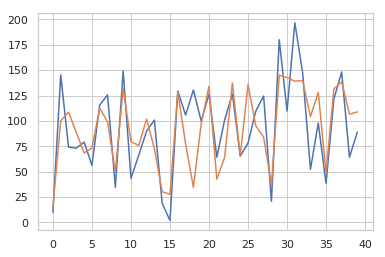

In [546]:
plt.plot(list(tmp2['y'])[:40])
plt.plot(list(tmp2['pred'])[:40])

In [454]:
train.loc[[0], ['2016-01', '2017-01', '2019-01']]

,2016-01,2017-01,2019-01
0,26.71,5.93,9.88


In [417]:
index_list[-10:]

[65773, 65774, 65777, 65778, 65779, 65780, 65781, 65782, 65783, 65784]

In [401]:
y.loc[valid_index].index

Int64Index([    0,     1,     4,     5,     6,     7,     9,    10,    11,
               14,
            ...
            55320, 55321, 55323, 55324, 55325, 55326, 55328, 55330, 55332,
            55335],
           dtype='int64', length=27668)

In [367]:
tmp[['2018-01','2017-01','2016-01','y','pred' ]].head(20)

,2018-01,2017-01,2016-01,y,pred
0,6.91,5.93,26.71,9.88,18.541510
1,113.63,41.51,44.51,145.28,97.504555
4,108.69,113.66,130.58,74.12,117.937491
5,97.82,128.49,84.09,73.13,91.119250
6,71.14,39.53,50.45,79.06,63.530209
7,61.26,40.52,20.77,56.33,74.276925
9,117.58,133.43,118.71,115.63,110.741929
10,104.73,95.87,97.94,125.51,102.180794
11,51.38,14.82,18.79,34.59,45.102695
14,131.41,138.37,135.53,149.23,132.805877


In [299]:
X.loc[valid_index]

,2018-05,2017-03,2017-04,2017-05,2017-06,2017-07,2016-03,2016-04,2016-05,2016-06,2016-07,rolling_mean_2018-05_3,rolling_std_2018-05_3,rolling_min_2018-05_3,rolling_max_2018-05_3,rolling_mean_2017-05_3,rolling_std_2017-05_3,rolling_min_2017-05_3,rolling_max_2017-05_3,rolling_mean_2016-05_3,rolling_std_2016-05_3,rolling_min_2016-05_3,rolling_max_2016-05_3,rolling_mean_diff_3,rolling_mean_2018-05_5,rolling_std_2018-05_5,rolling_min_2018-05_5,rolling_max_2018-05_5,rolling_mean_2017-05_5,rolling_std_2017-05_5,rolling_min_2017-05_5,rolling_max_2017-05_5,rolling_mean_2016-05_5,rolling_std_2016-05_5,rolling_min_2016-05_5,rolling_max_2016-05_5,rolling_mean_diff_5,yearly_mean,yearly_std,yearly_max,yearly_min,yearly_max_min,yearly_diff1,yearly_diff2,recent_mean_6,recent_mean_6_80,recent_mean_6_20,recent_mean_3,recent_mean_3_80,recent_mean_3_20,recent_mean_2,recent_mean_2_80,recent_mean_2_20,recent_std_6,recent_std_3,recent_std_2,recent_diff1,recent_diff2,recent_diff3,zero_count,zero_count_recent
0,7.90,3.95,5.92,4.94,4.94,4.94,31.62,11.86,6.91,3.95,2.96,7.90,3.019045,3.95,9.88,4.94,0.565803,4.94,5.92,6.91,3.996503,3.95,11.86,2.96,7.90,3.738563,0.98,9.88,4.94,0.696506,3.95,5.92,6.91,11.789171,2.96,31.62,2.96,6.91,1.506796,7.90,4.94,2.96,2.96,0.99,7.900,8.89,6.91,8.89,9.484,8.296,8.890,9.484,8.296,3.534106,0.990000,1.400071,-1.98,-0.99,7.90,2,1
1,37.55,79.04,39.52,29.64,16.79,16.79,47.44,30.64,20.75,19.76,6.91,37.55,13.940503,26.68,54.35,29.64,11.397294,16.79,39.52,20.75,6.016181,19.76,30.64,7.91,37.55,27.364187,20.75,88.94,29.64,25.703580,16.79,79.04,20.75,15.067194,6.91,47.44,7.91,29.64,8.404763,37.55,20.75,16.80,7.91,16.80,71.645,113.63,54.34,54.35,75.104,44.270,45.950,50.990,40.910,34.030463,26.203181,11.879394,-16.80,-51.39,-81.02,0,0
4,0.00,27.66,91.89,23.71,29.64,20.75,29.65,197.68,59.30,38.54,19.76,0.00,56.487950,0.00,97.84,29.64,37.768461,23.71,91.89,59.30,86.511600,38.54,197.68,-29.64,0.00,51.751919,0.00,97.84,27.66,29.916715,20.75,91.89,38.54,73.405455,19.76,197.68,-27.66,23.71,29.847675,59.30,0.00,59.30,-23.71,-59.30,94.380,108.69,74.10,90.92,95.072,36.368,48.920,78.272,19.568,41.702407,54.600059,69.183327,-97.84,-90.92,-111.65,1,1
5,32.61,64.22,61.26,20.75,21.73,8.89,83.02,84.01,54.36,23.72,10.87,32.61,24.815014,11.85,61.27,21.73,23.110753,20.75,61.26,54.36,30.146355,23.72,84.01,10.88,32.61,24.776523,8.89,61.27,21.73,25.512737,8.89,64.22,54.36,33.468841,10.87,84.01,10.88,32.61,17.045792,54.36,20.75,33.61,11.86,-21.75,66.700,97.82,58.30,58.30,60.082,42.886,46.940,55.538,38.342,25.375079,15.759614,20.265680,-28.66,-25.69,-66.20,2,0
6,37.55,47.42,31.61,24.70,16.79,12.84,80.06,60.29,16.80,17.79,15.81,37.55,25.720288,13.83,65.22,24.70,7.415621,16.79,31.61,17.79,24.828110,16.80,60.29,12.85,37.55,26.246894,13.83,68.19,24.70,13.672329,12.84,47.42,17.79,30.066823,15.81,80.06,12.85,24.70,10.472941,37.55,16.80,20.75,12.85,20.75,66.705,71.14,37.55,65.22,67.002,48.618,51.385,59.686,43.084,22.804467,16.898025,19.565645,-27.67,-30.64,-40.50,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55326,44.47,47.42,58.29,41.50,13.83,6.91,79.07,69.18,81.04,0.00,4.94,44.47,26.228796,15.81,68.19,41.50,22.450778,13.83,58.29,69.18,43.768355,0.00,81.04,2.97,44.47,35.311750,0.00,84.99,41.50,22.170966,6.91,58.29,69.18,40.795477,0.00,81.04,2.97,44.47,22.021192,81.04,41.50,39.54,2.97,-36.57,80.040,85.96,68.19,68.19,78.270,53.958,56.330,63.446,49.214,18.504346,20.358245,16.772573,-23.72,-40.52,-41.49,1,0
55328,14.82,28.65,20.75,9.88,9.88,8.89,37.55,17.79,13.83,8.89,7.90,14.82,8.556331,14.82,29.64,9.88,6.275797,9.88,20.75,13.83,4.458983,8.89,17.79,4.94,14.82,14.615672,9.88,45.46,9.88,8.764779,8.89,28.65,13.83,12.055842,7.90,37.55,4.94,13.83,2.613625,14.82,9.88,4.94,4.94,0.99,37.550,60.27,28.65,29.64,39.132,20.748,22.230,26.676,17.784,21.832731,15.322720,10.479322

In [296]:
for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
    print(fold_n)

0
1


In [297]:
valid_index

array([    0,     1,     4, ..., 55330, 55332, 55335])

In [207]:
X['zero_count_recent'].mean()

0.11950242110535983

In [208]:
X_test[X_test['zero_count_recent']==6]

,2018-05,2017-03,2017-04,2017-05,2017-06,2017-07,2016-03,2016-04,2016-05,2016-06,2016-07,rolling_mean_2018-05_3,rolling_std_2018-05_3,rolling_min_2018-05_3,rolling_max_2018-05_3,rolling_mean_2017-05_3,rolling_std_2017-05_3,rolling_min_2017-05_3,rolling_max_2017-05_3,rolling_mean_2016-05_3,rolling_std_2016-05_3,rolling_min_2016-05_3,rolling_max_2016-05_3,rolling_mean_diff_3,rolling_mean_2018-05_5,rolling_std_2018-05_5,rolling_min_2018-05_5,rolling_max_2018-05_5,rolling_mean_2017-05_5,rolling_std_2017-05_5,rolling_min_2017-05_5,rolling_max_2017-05_5,rolling_mean_2016-05_5,rolling_std_2016-05_5,rolling_min_2016-05_5,rolling_max_2016-05_5,rolling_mean_diff_5,yearly_mean,yearly_std,yearly_max,yearly_min,yearly_max_min,yearly_diff1,yearly_diff2,recent_mean_6,recent_mean_6_80,recent_mean_6_20,recent_mean_3,recent_mean_3_80,recent_mean_3_20,recent_mean_2,recent_mean_2_80,recent_mean_2_20,recent_std_6,recent_std_3,recent_std_2,recent_diff1,recent_diff2,recent_diff3,zero_count,zero_count_recent
271,0.0,34.58,43.47,32.60,24.70,15.80,78.08,38.54,28.66,25.69,20.75,11.85,8.048145,9.88,24.70,7.90,2.055245e+00,6.91,10.86,11.86,8.408486e+00,8.89,24.71,3.95,11.85,13.735284,9.88,41.50,7.90,6.648291,4.94,21.73,11.86,7.940294,6.91,24.71,3.95,28.66,17.793628,32.60,0.0,32.60,-32.60,-28.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,6
955,0.0,71.14,56.32,22.72,14.82,0.00,40.52,34.59,21.74,13.83,11.86,16.80,6.847374,16.80,28.66,19.76,5.704221e+00,19.76,29.64,20.75,3.995677e+00,15.81,23.72,-2.96,16.80,6.187680,14.82,28.66,19.76,4.909547,18.77,29.64,18.77,3.917905,13.83,23.72,-2.96,21.74,12.843847,22.72,0.0,22.72,-22.72,-21.74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,6
1022,0.0,47.42,43.47,22.72,8.89,8.89,50.40,40.52,28.66,10.87,10.87,5.92,2.486148,2.96,7.90,5.92,5.658033e-01,4.94,5.92,9.88,2.060849e+00,6.91,10.87,0.00,5.92,9.084147,2.96,24.70,5.92,0.880454,3.95,5.92,9.88,3.465650,4.94,13.83,0.00,22.72,15.126564,28.66,0.0,28.66,-22.72,-28.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6
1147,0.0,98.81,69.16,49.40,18.77,0.00,59.30,29.65,59.30,39.53,29.65,13.83,7.484713,1.97,15.81,11.85,1.544511e+01,0.00,30.63,10.87,1.284692e+01,9.88,32.61,1.98,11.85,6.156080,1.97,15.81,11.85,19.292766,0.00,48.41,10.87,16.526676,5.93,43.48,0.00,49.40,31.767016,59.30,0.0,59.30,-49.40,-59.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,6
1238,0.0,82.01,41.50,27.66,17.78,0.00,90.93,83.02,40.52,31.62,24.71,19.76,3.742357,13.83,20.75,15.80,1.507890e+00,14.82,17.78,26.68,1.261872e+01,9.88,34.59,3.96,19.76,13.049572,11.85,44.47,15.80,4.419589,11.85,23.71,26.68,14.316709,6.91,38.54,3.96,27.66,20.705577,40.52,0.0,40.52,-27.66,-40.52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,6
1386,0.0,45.45,44.46,25.69,16.79,18.77,50.40,28.66,22.73,15.81,14.82,10.87,15.883508,5.92,35.57,13.83,3.156464e+01,2.96,62.25,7.90,9.133681e+00,7.90,23.72,-2.96,10.87,33.394442,5.92,84.00,13.83,40.999591,0.98,92.88,7.90,22.952213,3.95,59.30,-2.96,22.73,14.055785,25.69,0.0,25.69,-25.69,-22.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,6
1783,0.0,98.81,107.70,44.46,21.73,15.80,103.78,56.33,53.37,12.84,6.91,13.83,10.568448,12.84,31.62,6.91,1.512250e+00,5.92,8.89,0.98,3.423687e+00,0.98,6.91,6.92,13.83,20.427100,3.95,55.34,6.91,2.360244,3.95,9.88,0.98,29.947260,0.98,69.18,6.92,44.46,28.590315,53.37,0.0,53.37,-44.46,-53.37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6
1835,0.0,71.14,64.22,28.65,18.77,19.76,110.70,53.37,32.61,19.76,18.77,52.37,32.635129,21.74,86.97,60.27,3.180264e+01,14.82,76.08,55.35,2.308288e+01,39.53,85.00,-7.90,52.37,49.054135,10.87,130.45,60.27,34.302579,10.86,83.98,55.35,34.744304,28.66,113.66,-7.90,28.65,17.794738,32.61,0.0,32.61,-28.65,-32.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,6
2000,0.0,10.86,1.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,36.56,21.774876,12.84,56.33,43.47,2.591713e+01,11.85,63.23,60.29,5.797806e+01,9.88,125.52,-6.91,3

In [129]:
score_list

[9.573002497836292,
 7.892065242124982,
 6.667031888588962,
 6.856590606462325,
 9.868063417455371,
 18.727905923505944,
 27.495785352829607,
 39.32670350998595,
 38.050565539720004,
 31.860818135469955,
 27.923085599863015,
 16.553509767384618]

In [130]:
np.mean(score_list)

20.066260623435586

In [121]:
score_list

[9.569013925130275,
 7.892298167486587,
 6.6733482647941145,
 6.852739541068532,
 9.876451051389754,
 18.74766406902277,
 27.50351991222395,
 39.35802220144703,
 38.03749754268231,
 31.88313364717783,
 27.89981056928645,
 16.5562592070405]

In [122]:
np.mean(score_list)

20.070813174895843

In [276]:
train.values

array([[  3.95,   3.95,   6.92, ...,   2.96,   7.9 ,   4.94],
       [ 14.83,  11.87,   7.91, ...,  62.26,  58.31,  32.61],
       [  9.89,   1.97,  11.87, ...,   0.  ,   0.  ,   0.  ],
       ...,
       [  4.94,   6.92,   6.92, ...,  17.79,   9.88,   6.91],
       [ 28.68,  26.71,  17.8 , ..., 100.81,  91.92,  39.53],
       [ 37.59,  29.67,  16.81, ...,  65.23,   0.  ,   0.  ]])

In [284]:
train.values = scaler.transform(train)#scaler.inverse_transform(scaler.transform(train))

/home/dohee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


AttributeError: can't set attribute

In [279]:
scaler.mean_.shape

(48,)

In [227]:
np.mean(score_list)

20.01436949670812

In [224]:
np.mean(score_list)

20.087690272056992

In [207]:
np.mean(score_list)

20.096321776342183

In [197]:
np.mean(score_list)

20.08702748307288

In [169]:
np.mean(score_list)

20.300403871608776

In [225]:
score = round(np.mean(score_list),5)

sample_submission.to_csv('../code/submission'+'_'+str(score).replace('.', '_')+'.csv', index=False)
pd.read_csv('../code/'+'submission'+'_'+str(score).replace('.', '_')+'.csv')

,id,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
0,78587,22.867672,13.504789,6.904318,6.708575,12.511357,29.954466,53.158138,77.919598,72.554225,50.455387,36.824537,14.213790
1,78588,21.708639,16.264488,11.444736,10.081738,17.008306,29.967087,43.062362,85.333727,78.818130,66.491650,54.992385,38.520109
2,78589,13.427914,10.793719,7.154778,8.222853,14.442867,24.020496,54.681652,77.755490,85.929820,64.261753,48.589451,33.399861
3,78590,20.102681,15.816006,9.448068,11.932690,22.439391,35.207687,67.400881,83.727594,80.279246,75.887678,63.160506,37.553974
4,78591,19.200467,13.872307,7.021609,7.951847,13.133362,27.733208,50.706548,81.746172,71.814727,56.126768,37.652989,19.347286
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,88582,26.114883,17.002524,6.282913,7.300672,18.304536,37.292680,72.298001,126.219705,120.389904,77.965223,43.869648,15.463435
9996,88583,29.188792,19.050837,12.197355,11.945817,19.213900,54.059576,96.293296,175.585564,171.480183,121.770894,101.931531,56.545392
9997,88584,6.619905,5.450181,4.968975,3.531997,9.963213,19.615486,40.858164,40.388075,47.893212,52.630303,42.673067,24.594233
9998,88585,11.658705,4.813159,3.273816,4.765815,6.715537,13.337452,30.644221,63.341431,57.778921,38.935942,29.114298,11.311406


In [147]:
score

17.023346377968977

In [117]:
np.mean(score_list)

18.60909420895923

In [97]:
np.mean(score_list)

18.60909420895923

In [53]:
np.mean(score_list)

20.72457339771162

In [50]:
np.mean(score_list)

20.300403871608776

In [47]:
np.mean(score_list)

20.72457339771162

In [44]:
np.mean(score_list)

20.72457339771162

In [35]:
np.mean(score_list)

20.300403871608776

In [905]:
np.mean(score_list)

20.300403871608776

In [892]:
np.mean(score_list)

20.538399446600472

In [818]:

# Center = False (20.678905378143856)
np.mean(score_list)

20.678905378143856

In [822]:
# Center = True
np.mean(score_list)

20.548060000003392

In [897]:
def fe_old(idx, train, istest=False): #, istest=False
    
    # create dataframe
    df = pd.DataFrame()
    all_cols = list(train.columns)
    
    if istest==False:
        idx -= 12
        print("month:", all_cols[idx])
        
    # previous year
    df['prev1'] = train[all_cols[idx-12]]
    df['prev1_2'] = train[all_cols[idx-12-1]]
    df['prev1_3'] = train[all_cols[idx-12-2]]
    df['prev2'] = train[all_cols[idx-24]]
    df['prev2_2'] = train[all_cols[idx-24-1]]
    df['prev3'] = train[all_cols[idx-36]]
    
    print(all_cols[idx-12])
    print(all_cols[idx-13])
    print(all_cols[idx-14])
    print(all_cols[idx-24])
    print(all_cols[idx-25])
    print(all_cols[idx-36])

    
    #지난해 근방의 평균
    df['sur1'] = (train[all_cols[idx-13]] + train[all_cols[idx-12]])/2
    df['sur2'] = (train[all_cols[idx-14]] + train[all_cols[idx-13]] + train[all_cols[idx-12]])/3
    df['sur3'] = (train[all_cols[idx-15]] + train[all_cols[idx-14]] + train[all_cols[idx-13]]
                  + train[all_cols[idx-12]])/4

    if istest==False:
        print(all_cols)
        print("length:", len(all_cols))
        print("지난해:", all_cols[idx-24:idx-12])
        print("지난 2년:", all_cols[idx-36:idx-12])
        print("최근 6개월:", all_cols[-18:-12])
    
        # 지난해의 평균
        df['avg'] = train[all_cols[idx-24:idx-12]].mean(axis=1)

        # 지난해의 분산
        df['std'] = train[all_cols[idx-24:idx-12]].std(axis=1)

        # 지난 2년간 0의 count
        df['zero_count'] = (train[all_cols[idx-48:idx-12]]==0).sum(axis=1)

        # 최근 0의 count
        df['zero_count_recent'] = (train[all_cols[-18:-12]]==0).sum(axis=1)
        
    else:
        print("지난해:", all_cols[idx-24:idx-12])
        print("지난 2년:", all_cols[idx-36:idx-12])
        print("최근 6개월:", all_cols[-6:])
        
        # 지난해의 평균
        df['avg'] = train[all_cols[idx-24:idx-12]].mean(axis=1)

        # 지난해의 분산
        df['std'] = train[all_cols[idx-24:idx-12]].std(axis=1)

        # 지난 2년간 0의 count
        df['zero_count'] = (train[all_cols[idx-36:idx-12]]==0).sum(axis=1)

        # 최근 0의 count
        df['zero_count_recent'] = (train[all_cols[-6:]]==0).sum(axis=1)


    # target
    if istest==False:
        df['target'] = train[all_cols[idx]]

        # 0이 많은곳 없애기
        df = df[df['zero_count_recent']<=1]
        df = df[df['zero_count']<=3]
        df = df.reset_index(drop=True)
        
    return df

In [773]:
# Old version

















0it [00:00, ?it/s]

month: 2018-06
month: 2018-06
2017-06
2017-05
2017-04
2016-06
2016-05
2015-06
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05']
지난 2년: ['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017

















1it [00:01,  1.03s/it]

month: 2018-07
month: 2018-07
2017-07
2017-06
2017-05
2016-07
2016-06
2015-07
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06']
지난 2년: ['2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017

















2it [00:02,  1.01s/it]

month: 2018-08
month: 2018-08
2017-08
2017-07
2017-06
2016-08
2016-07
2015-08
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07']
지난 2년: ['2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017

















3it [00:02,  1.00s/it]

month: 2018-09
month: 2018-09
2017-09
2017-08
2017-07
2016-09
2016-08
2015-09
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08']
지난 2년: ['2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017

















4it [00:03,  1.02it/s]

month: 2018-10
month: 2018-10
2017-10
2017-09
2017-08
2016-10
2016-09
2015-10
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09']
지난 2년: ['2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017

















5it [00:05,  1.07s/it]

month: 2018-11
month: 2018-11
2017-11
2017-10
2017-09
2016-11
2016-10
2015-11
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10']
지난 2년: ['2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017

















6it [00:06,  1.08s/it]

month: 2018-12
month: 2018-12
2017-12
2017-11
2017-10
2016-12
2016-11
2015-12
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11']
지난 2년: ['2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017

















7it [00:07,  1.09s/it]

month: 2019-01
month: 2019-01
2018-01
2017-12
2017-11
2017-01
2016-12
2016-01
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12']
지난 2년: ['2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017

















8it [00:08,  1.05s/it]

month: 2019-02
month: 2019-02
2018-02
2018-01
2017-12
2017-02
2017-01
2016-02
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01']
지난 2년: ['2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017

















9it [00:09,  1.11s/it]

month: 2019-03
month: 2019-03
2018-03
2018-02
2018-01
2017-03
2017-02
2016-03
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02']
지난 2년: ['2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017

















10it [00:10,  1.13s/it]

month: 2019-04
month: 2019-04
2018-04
2018-03
2018-02
2017-04
2017-03
2016-04
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03']
지난 2년: ['2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018

















11it [00:12,  1.29s/it]

month: 2019-05
month: 2019-05
2018-05
2018-04
2018-03
2017-05
2017-04
2016-05
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04']
지난 2년: ['2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018

















12it [00:13,  1.17s/it]


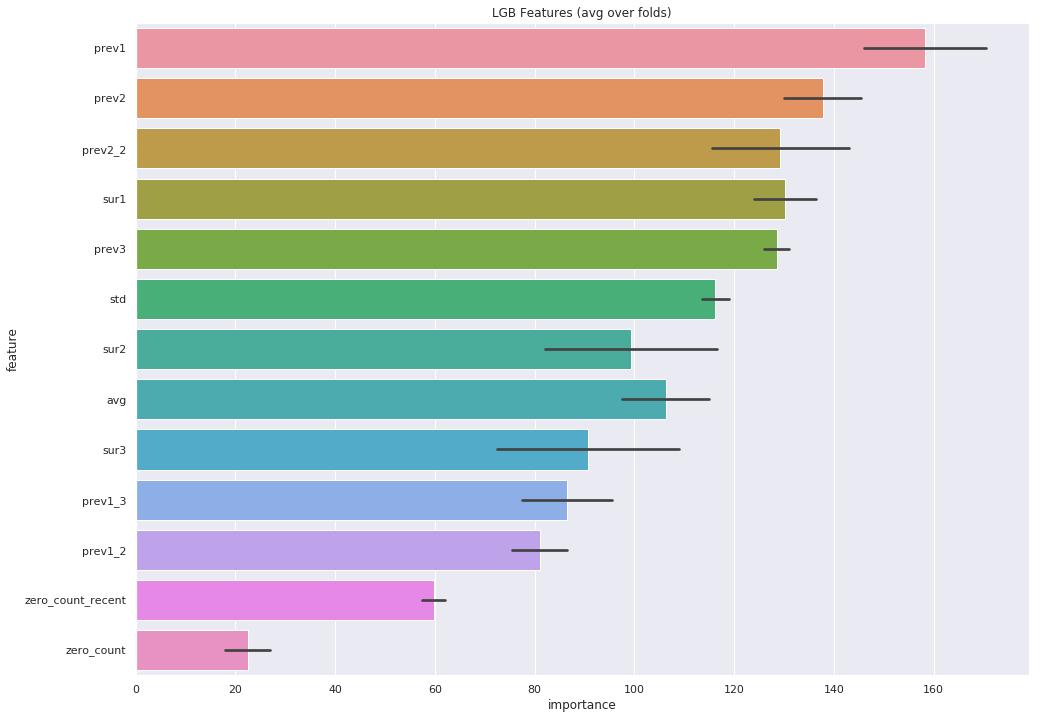

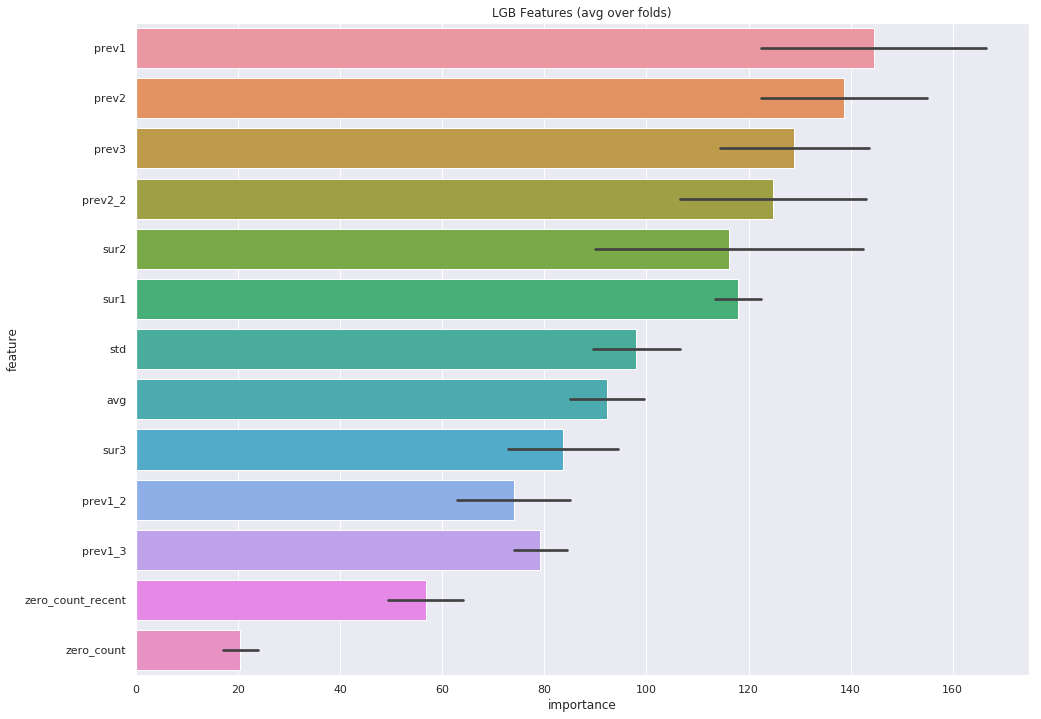

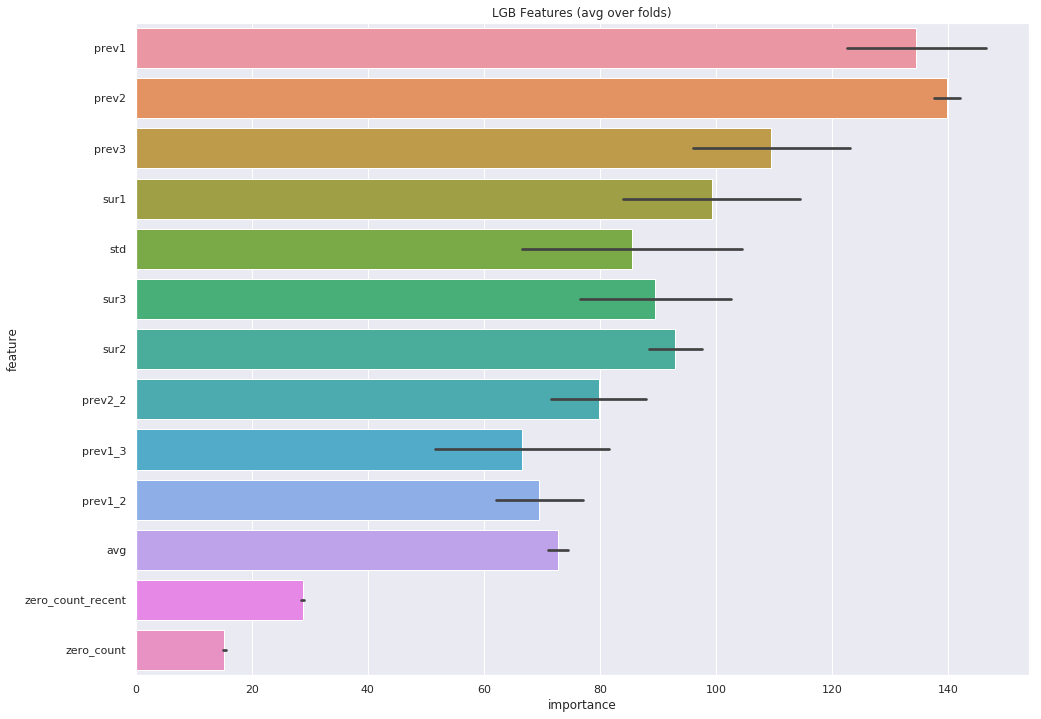

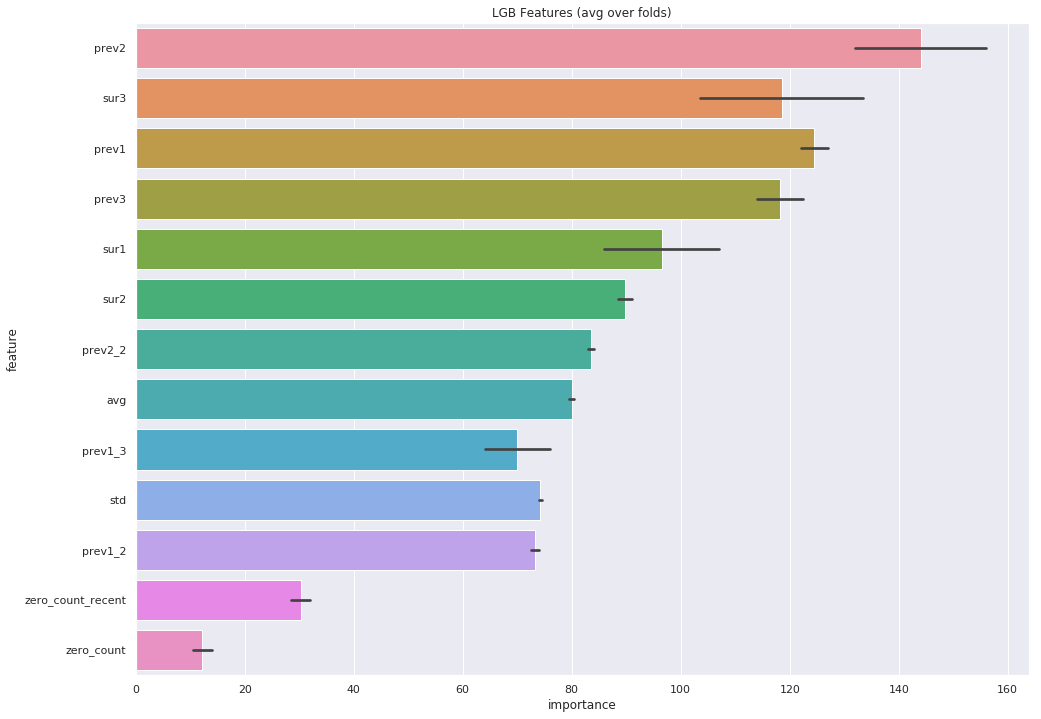

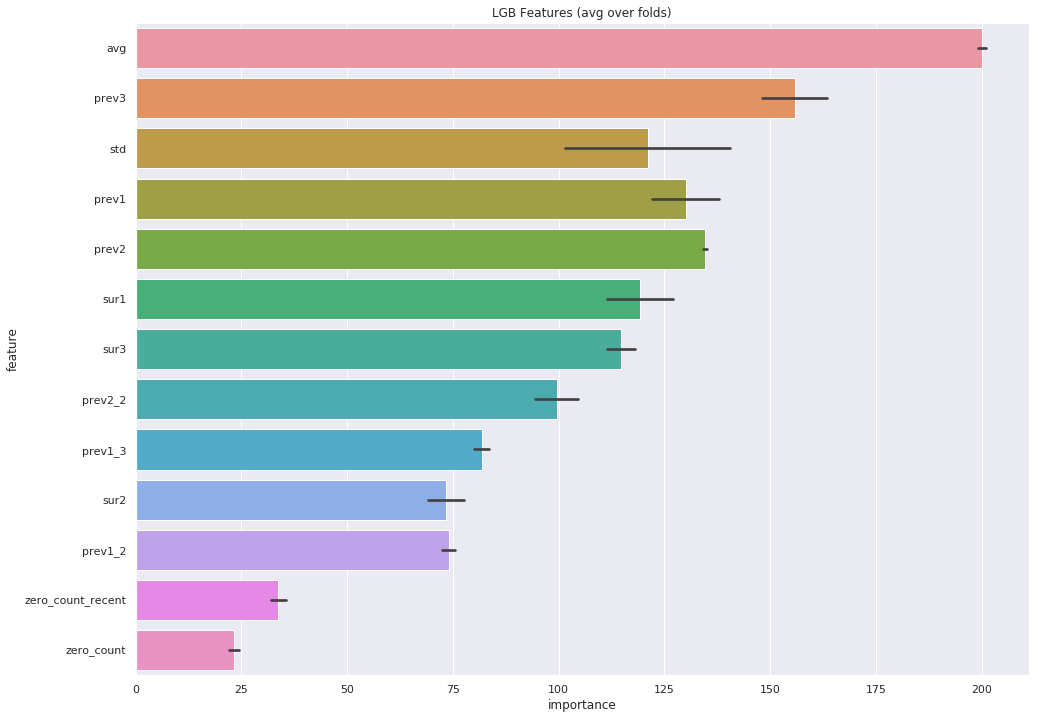

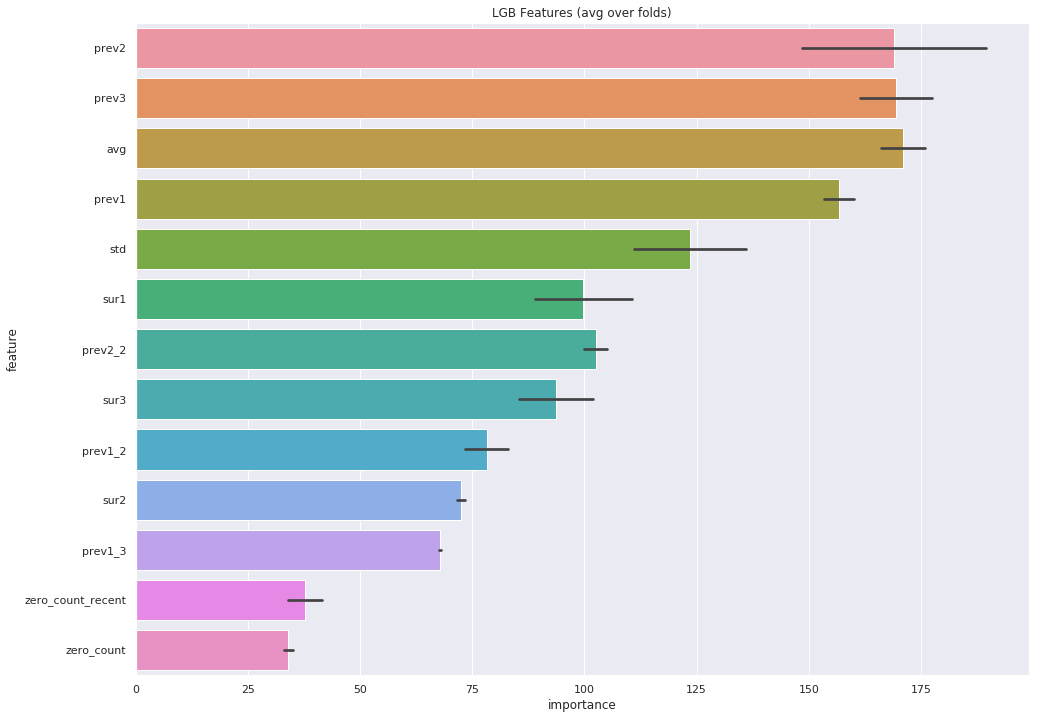

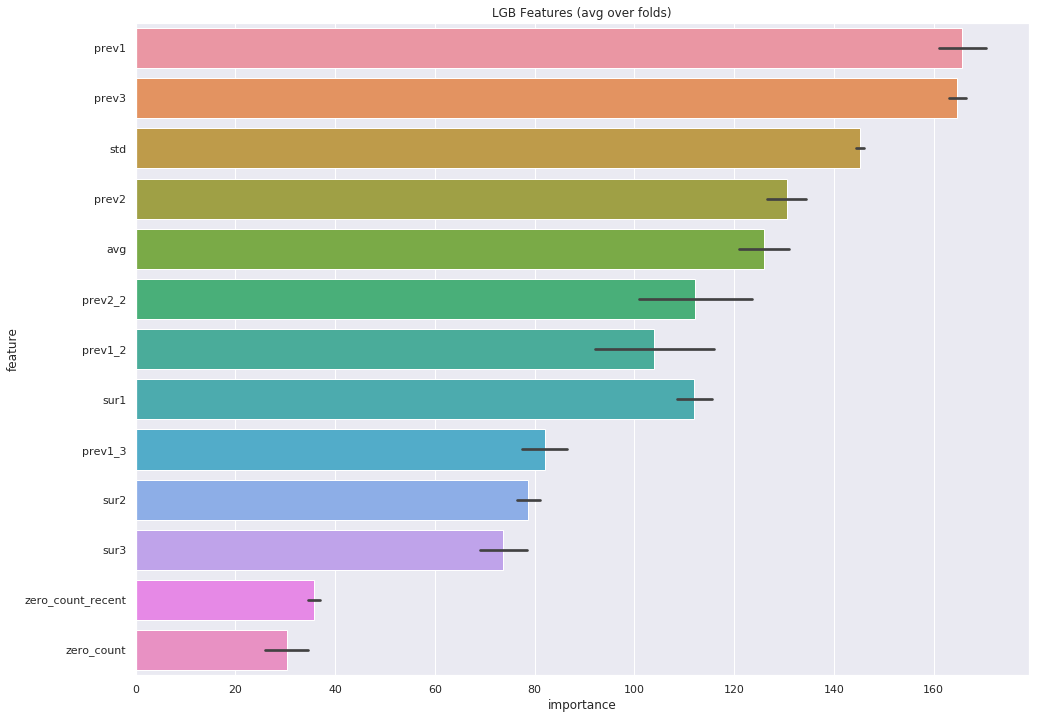

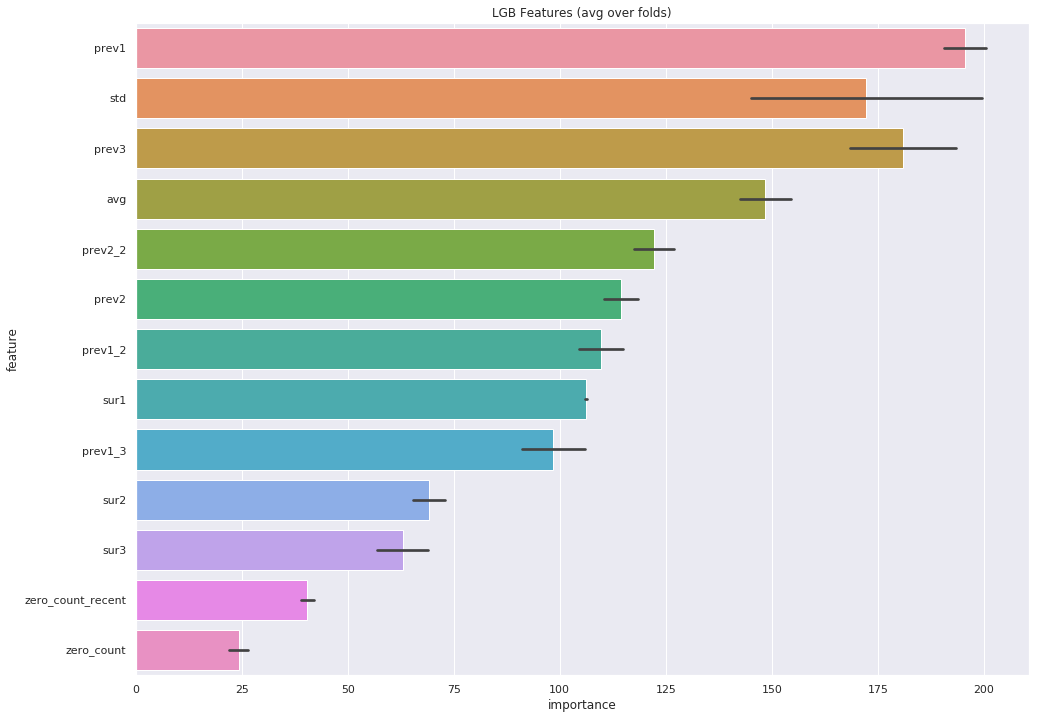

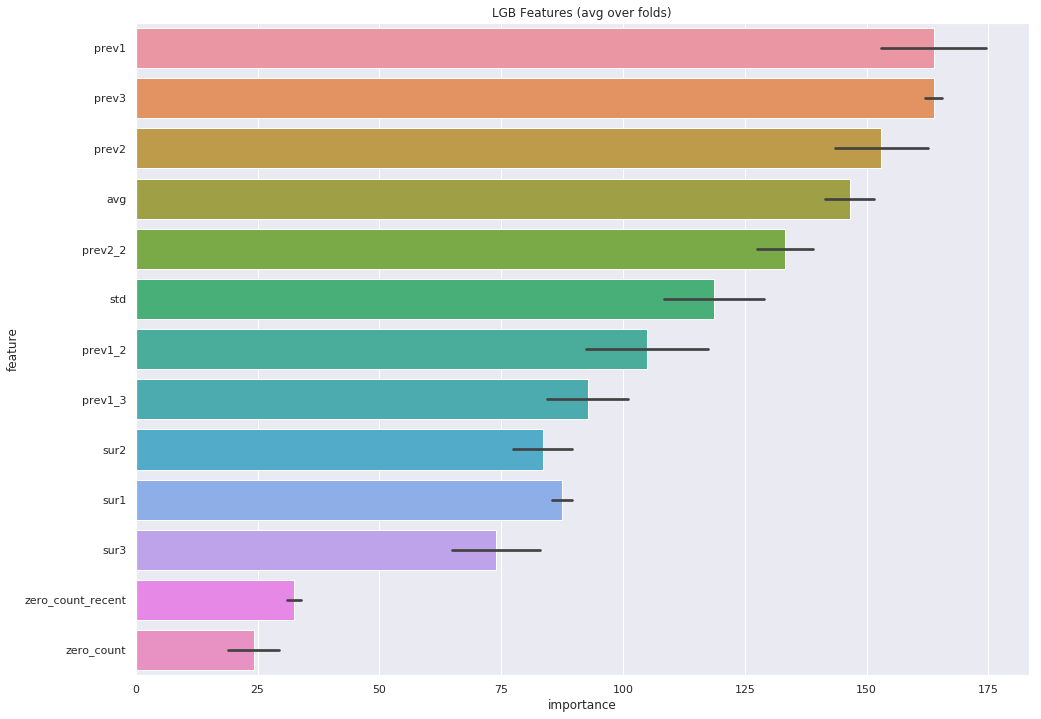

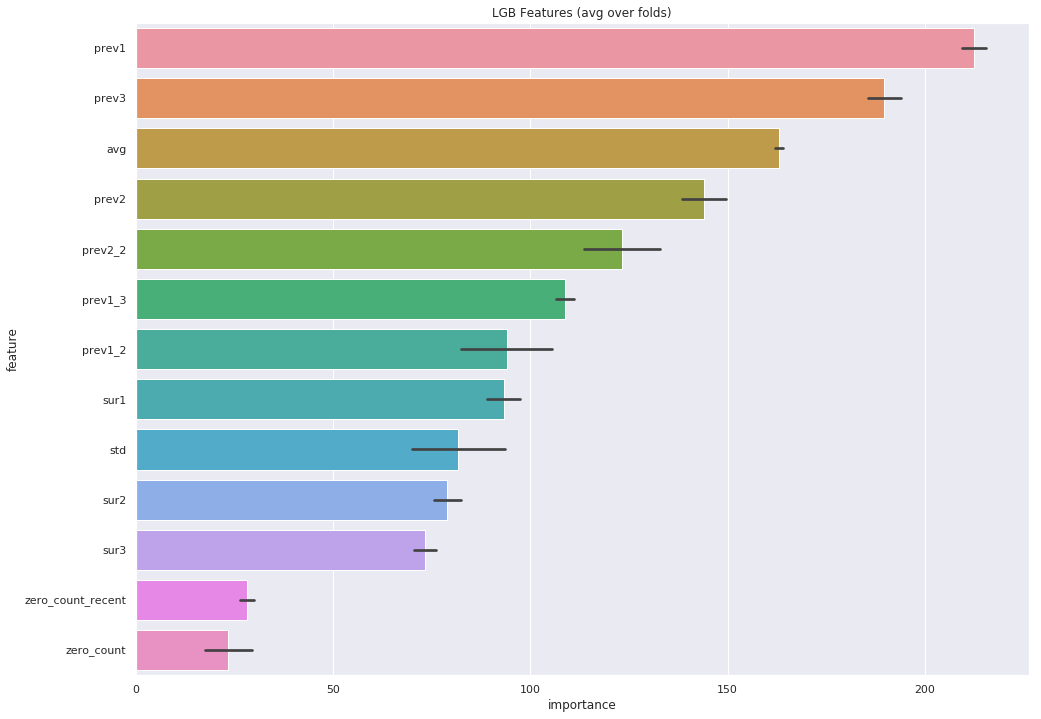

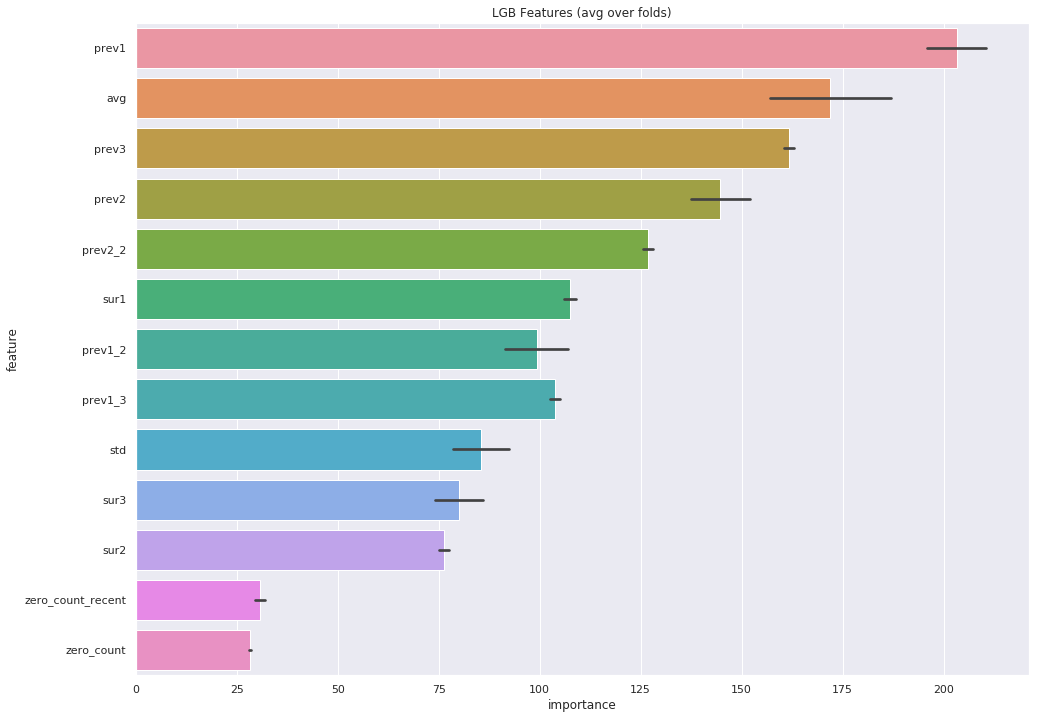

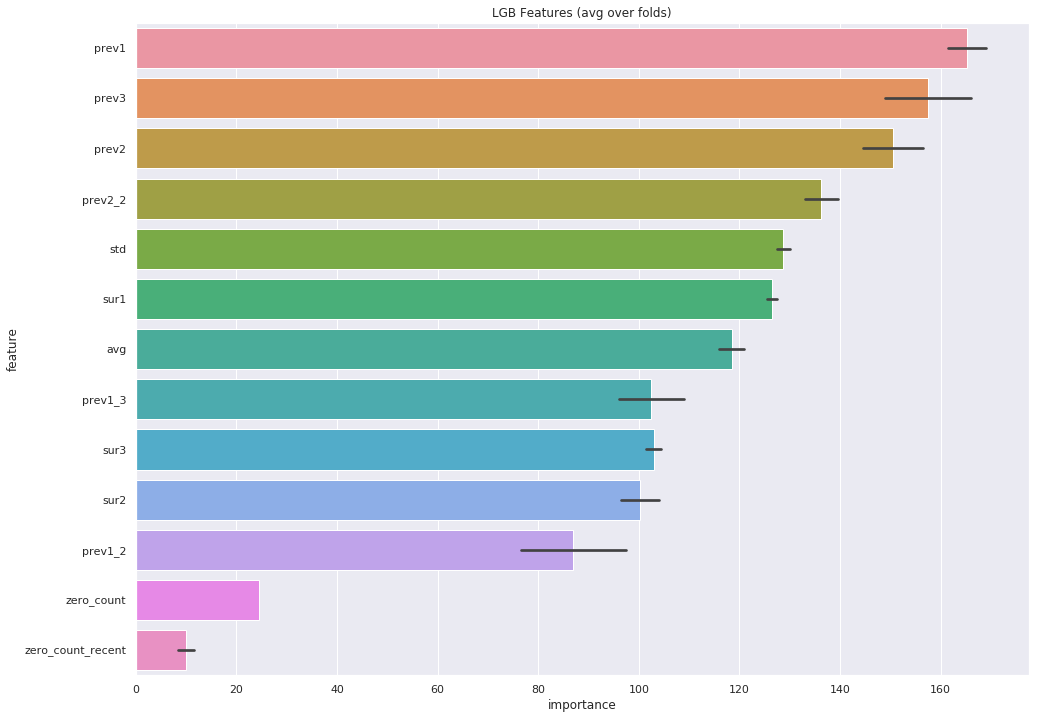

In [774]:
folds = KFold(n_splits=2, shuffle=True, random_state=7)
score_list = []
for idx, month in tqdm(enumerate(list(sample_submission.columns[1:]))): 
    
    print("month:", month)
    all_cols = list(train.columns)
    
    train_df = fe_old(idx, train)
    test_df = fe_old(idx, test, True)
    
    if TRAINING: 
        cols = [c for c in train_df.columns if c not in ['target']]
        X = train_df[cols]
        y = train_df['target']
    
    X_test = test_df[cols]
    
    result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, model_type=MODEL_TYPE, eval_metric='rmse', plot_feature_importance=True,
                                                          early_stopping_rounds=150)
    score_list.append(np.mean(result_dict_lgb['scores']))
    sample_submission[month] = result_dict_lgb['prediction']

In [775]:
score = round(np.mean(score_list),5)
score

21.03265

In [748]:
score = round(np.mean(score_list),5)
score

21.5508

In [741]:
score = round(np.mean(score_list),5)
score

21.5508

In [205]:
sample_submission.to_csv('../code/submission'+'_'+str(score).replace('.', '_')+'.csv', index=False)
pd.read_csv('../code/'+'submission'+'_'+str(score).replace('.', '_')+'.csv')

,id,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
0,78587,20.489315,16.816352,16.209278,21.320565,21.009815,24.624274,41.649352,60.265954,57.556045,45.315669,27.907567,19.870688
1,78588,23.415072,17.417440,20.337069,17.310516,26.281139,29.318293,45.425640,72.887768,62.841577,42.915695,31.789427,28.611428
2,78589,14.895435,12.297115,8.840572,12.070084,15.232550,20.097663,28.953902,60.098552,55.494560,41.677249,24.665372,14.918129
3,78590,17.917696,12.594719,12.657004,22.033857,19.525876,21.803798,36.999307,57.111049,49.479058,34.517996,24.633622,19.711072
4,78591,19.725956,17.043180,12.758868,17.504538,20.345945,23.225957,37.905492,65.934697,59.436986,46.362133,25.847666,18.695458
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,88582,25.321331,21.526776,20.850858,15.400407,32.232150,33.332342,51.556545,120.634433,68.164409,73.408846,37.094230,25.560589
9996,88583,24.961735,19.491847,13.879740,24.768898,21.632846,34.308296,73.221302,126.946646,123.009589,103.466364,35.165631,25.183069
9997,88584,6.514598,5.333879,4.681425,5.374016,7.865804,9.999364,15.540669,31.346159,30.377206,21.175236,13.480569,7.335804
9998,88585,15.956397,13.001499,11.940334,13.499312,17.350487,23.061260,28.208371,59.924095,52.507703,35.378926,25.668027,19.193082


In [176]:
X_test

,prev1,prev1_2,prev1_3,prev2,prev2_2,prev3,sur1,sur2,sur3,avg,std,zero_count,zero_count_recent
0,15.80,23.71,74.10,19.76,39.53,14.83,19.755,37.870000,47.4225,42.320833,31.272425,0,0
1,25.69,51.38,81.02,14.82,76.10,36.60,38.535,52.696667,58.7900,39.605000,30.596408,0,0
2,12.84,14.82,38.53,10.87,14.82,9.89,13.830,22.063333,31.6150,35.569167,31.579668,0,0
3,10.86,34.58,63.23,20.75,25.69,12.86,22.720,36.223333,48.4100,31.287500,24.172970,0,0
4,14.82,19.76,61.26,16.80,19.76,16.81,17.290,31.946667,42.4850,41.005000,31.013192,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24.70,33.59,78.05,21.74,39.53,13.85,29.145,45.446667,67.1850,64.637500,61.525846,0,0
9996,12.84,29.64,83.00,19.76,49.42,13.85,21.240,41.826667,53.6000,88.025000,93.515252,0,0
9997,4.94,5.92,15.80,4.94,3.95,3.95,5.430,8.886667,7.9000,12.181667,12.543707,0,0
9998,18.77,20.75,19.76,16.80,18.77,16.81,19.760,19.760000,20.2525,27.580833,26.963215,1,0


In [186]:
from sklearn.model_selection import KFold
from tqdm import tqdm

plot_feature_importance = True
n_splits = 2
model_type = 'lgb'

columns = list(train_df.columns)
columns.remove('target')

folds = KFold(n_splits=n_splits, shuffle=True, random_state=123)
feature_importance = pd.DataFrame()
score_list = []
for idx, month in tqdm(enumerate(list(sample_submission.columns[1:]))):
    sub_preds = np.zeros(test.shape[0])


    
    if TRAINING: 
        cols = [c for c in train_df.columns if c not in ['target']]
        X = train_df[cols]
        y = train_df['target']
    
    
    # 0값이 많은 곳 없애기
    train_df = train_df[train_df['zero_count_recent']<=1]
    train_df = train_df[train_df['zero_count']<=3]
    train_df = train_df.reset_index(drop=True)

    
    

    
    score = 0
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_df)):
        x_train = train_df.loc[trn_idx]
        y_train = train_df['target'][trn_idx]
        x_val = train_df.loc[val_idx]
        y_val = train_df['target'][val_idx]
        model, result, val_score = run_lgb(x_train, y_train, x_val, y_val, test_df)
        sub_preds += result['demand'] / folds.n_splits
        score += val_score/n_splits
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = n_fold + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

        
        
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance


    print("total score:", score)
    score_list.append(score)
    sample_submission[month] = sub_preds
    
print("validation score:", np.mean(score))





0it [00:00, ?it/s]

processing..  2018-06
2017-06
Training until validation scores don't improve for 400 rounds
[100]	training's rmse: 12.8052	valid_1's rmse: 13.0295
[200]	training's rmse: 11.4713	valid_1's rmse: 11.7884
[300]	training's rmse: 10.823	valid_1's rmse: 11.2167
[400]	training's rmse: 10.4932	valid_1's rmse: 10.9469
[500]	training's rmse: 10.3117	valid_1's rmse: 10.8192
[600]	training's rmse: 10.1961	valid_1's rmse: 10.75
[700]	training's rmse: 10.1134	valid_1's rmse: 10.7076
[800]	training's rmse: 10.0547	valid_1's rmse: 10.6844
[900]	training's rmse: 10.0016	valid_1's rmse: 10.6679
[1000]	training's rmse: 9.95558	valid_1's rmse: 10.6557
[1100]	training's rmse: 9.91705	valid_1's rmse: 10.6485
[1200]	training's rmse: 9.87775	valid_1's rmse: 10.6411
[1300]	training's rmse: 9.84134	valid_1's rmse: 10.6364
[1400]	training's rmse: 9.80708	valid_1's rmse: 10.6326
[1500]	training's rmse: 9.77526	valid_1's rmse: 10.6292
[1600]	training's rmse: 9.74293	valid_1's rmse: 10.6262
[1700]	training's rmse: 

AttributeError: 'Booster' object has no attribute 'feature_importances_'

In [ ]:
from sklearn.model_selection import KFold

folds = KFold(n_splits=5, shuffle=True, random_state=123)
score_list = []
for idx, month in enumerate(list(sample_submission.columns[1:])):
    sub_preds = np.zeros(test.shape[0])
    train_df = fe(36+idx, train)
    test_df = fe(36+idx, test, True)
    
    # 0값이 많은 곳 없애기
    train_df = train_df[train_df['zero_count_recent']<=1]
    train_df = train_df[train_df['zero_count']<=3]
    train_df = train_df.reset_index(drop=True)
    
    
    score = 0
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_df)):
        x_train = train_df.loc[trn_idx]
        y_train = train_df['target'][trn_idx]
        x_val = train_df.loc[val_idx]
        y_val = train_df['target'][val_idx]
        result, val_score = run_lgb(x_train, y_train, x_val, y_val, test_df)
        sub_preds += result['demand'] / folds.n_splits
        score += val_score/5

    print("total score:", score)
    score_list.append(score)
    sample_submission[month] = sub_preds
    
print("validation score:", np.mean(score))

In [ ]:
# old version 2

In [759]:
def run_lgb(x_train, y_train, x_val, y_val, test_df):
    
    features = list(x_train.columns)[:-1]
    #gc.collect()

    params = {
        'boosting_type': 'gbdt',
        'objective': 'poisson',
        'metric': 'rmse',
        'learning_rate': 0.01,
        'num_leaves':255,
        'max_depth': 8,  
        'min_child_samples': 100,  
        'max_bin': 100,  
        'subsample': 0.7,  
        'subsample_freq': 1,  
        'colsample_bytree': 0.7,  
        'min_child_weight': 0,  
        'subsample_for_bin': 200000,  
        'min_split_gain': 0,  
        'reg_alpha': 0,  
        'reg_lambda': 0,  
       # 'nthread': 8,
        'verbose': 0,
        'scale_pos_weight':99 
        }

    
#     params = {
# #         'boosting_type': 'gbdt',
#         'metric': 'rmse',
#         'objective': 'poisson',
#         'n_jobs': -1,
#         'seed': 20,
#         'learning_rate': 0.1,
#         'alpha': 0.1,
#         'lambda': 0.1,
#         'bagging_fraction': 0.66,
#         'bagging_freq': 2, 
#         'colsample_bytree': 0.77}

    train_set = lgb.Dataset(x_train[features], y_train)
    val_set = lgb.Dataset(x_val[features], y_val)
    
    del x_train, y_train
    
    model = lgb.train(params, train_set, num_boost_round = 5000, early_stopping_rounds = 400, valid_sets = [train_set, val_set], verbose_eval = 100)
    joblib.dump(model, 'lgbm_0.sav')
    
    val_pred = model.predict(x_val[features], num_iteration=model.best_iteration)
    val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
    print(f'Our val rmse score is {val_score}')
    y_pred = model.predict(test_df[features], num_iteration=model.best_iteration)
    test_df['demand'] = y_pred
    return test_df, val_score
    
score_list = []
    
for idx, month in enumerate(list(sample_submission.columns[1:])):

    print("month:", month)
    train_df = fe_old(idx, train)
    test_df = fe_old(idx, test, True)
    
    score = 0
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_df)):
        x_train = train_df.loc[trn_idx]
        y_train = train_df['target'][trn_idx]
        x_val = train_df.loc[val_idx]
        y_val = train_df['target'][val_idx]
        result, val_score = run_lgb(x_train, y_train, x_val, y_val, test_df)
        sub_preds += result['demand'] / folds.n_splits
        score += val_score/folds.n_splits
    score_list.append(score)

month: 2018-06
month: 2018-06
2017-06
2017-05
2017-04
2016-06
2016-05
2015-06
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05']
length: 48
지난해: ['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05']
지난 2년: ['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017

Training until validation scores don't improve for 400 rounds
[100]	training's rmse: 8.04888	valid_1's rmse: 7.94203
[200]	training's rmse: 7.38537	valid_1's rmse: 7.33724
[300]	training's rmse: 7.08624	valid_1's rmse: 7.08826
[400]	training's rmse: 6.9438	valid_1's rmse: 6.98636
[500]	training's rmse: 6.86783	valid_1's rmse: 6.94509
[600]	training's rmse: 6.82041	valid_1's rmse: 6.92775
[700]	training's rmse: 6.78611	valid_1's rmse: 6.92055
[800]	training's rmse: 6.76035	valid_1's rmse: 6.91733
[900]	training's rmse: 6.73913	valid_1's rmse: 6.91624
[1000]	training's rmse: 6.72034	valid_1's rmse: 6.916
[1100]	training's rmse: 6.70115	valid_1's rmse: 6.91626
[1200]	training's rmse: 6.68478	valid_1's rmse: 6.91642
[1300]	training's rmse: 6.66735	valid_1's rmse: 6.91652
[1400]	training's rmse: 6.65218	valid_1's rmse: 6.91713
Early stopping, best iteration is:
[1029]	training's rmse: 6.7145	valid_1's rmse: 6.91579
Our val rmse score is 6.915793026834709
Training until validation scores don

[200]	training's rmse: 11.1617	valid_1's rmse: 11.2205
[300]	training's rmse: 10.6725	valid_1's rmse: 10.8127
[400]	training's rmse: 10.4452	valid_1's rmse: 10.6485
[500]	training's rmse: 10.3287	valid_1's rmse: 10.5835
[600]	training's rmse: 10.258	valid_1's rmse: 10.5573
[700]	training's rmse: 10.211	valid_1's rmse: 10.5463
[800]	training's rmse: 10.1749	valid_1's rmse: 10.5432
[900]	training's rmse: 10.1449	valid_1's rmse: 10.5425
[1000]	training's rmse: 10.1191	valid_1's rmse: 10.5432
[1100]	training's rmse: 10.0966	valid_1's rmse: 10.5457
[1200]	training's rmse: 10.0743	valid_1's rmse: 10.5484
Early stopping, best iteration is:
[882]	training's rmse: 10.1501	valid_1's rmse: 10.5423
Our val rmse score is 10.542279001924328
month: 2018-11
month: 2018-11
2017-11
2017-10
2017-09
2016-11
2016-10
2015-11
['2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10

Training until validation scores don't improve for 400 rounds
[100]	training's rmse: 52.7857	valid_1's rmse: 52.9064
[200]	training's rmse: 46.3994	valid_1's rmse: 46.6468
[300]	training's rmse: 43.611	valid_1's rmse: 44.0167
[400]	training's rmse: 42.3744	valid_1's rmse: 42.9463
[500]	training's rmse: 41.7943	valid_1's rmse: 42.5135
[600]	training's rmse: 41.4851	valid_1's rmse: 42.3406
[700]	training's rmse: 41.2929	valid_1's rmse: 42.2647
[800]	training's rmse: 41.1619	valid_1's rmse: 42.2352
[900]	training's rmse: 41.0602	valid_1's rmse: 42.2236
[1000]	training's rmse: 40.973	valid_1's rmse: 42.2206
[1100]	training's rmse: 40.8896	valid_1's rmse: 42.2208
[1200]	training's rmse: 40.8164	valid_1's rmse: 42.2238
[1300]	training's rmse: 40.742	valid_1's rmse: 42.2286
[1400]	training's rmse: 40.6705	valid_1's rmse: 42.2325
Early stopping, best iteration is:
[1045]	training's rmse: 40.9375	valid_1's rmse: 42.2185
Our val rmse score is 42.218494660778106
Training until validation scores d

Our val rmse score is 33.59176091808798
Training until validation scores don't improve for 400 rounds
[100]	training's rmse: 40.4649	valid_1's rmse: 40.6548
[200]	training's rmse: 35.9098	valid_1's rmse: 36.4354
[300]	training's rmse: 33.9184	valid_1's rmse: 34.7239
[400]	training's rmse: 33.0291	valid_1's rmse: 34.0475
[500]	training's rmse: 32.5973	valid_1's rmse: 33.7868
[600]	training's rmse: 32.3538	valid_1's rmse: 33.6831
[700]	training's rmse: 32.2005	valid_1's rmse: 33.637
[800]	training's rmse: 32.0903	valid_1's rmse: 33.6187
[900]	training's rmse: 32.0049	valid_1's rmse: 33.6074
[1000]	training's rmse: 31.9316	valid_1's rmse: 33.6035
[1100]	training's rmse: 31.8653	valid_1's rmse: 33.6023
[1200]	training's rmse: 31.805	valid_1's rmse: 33.6052
[1300]	training's rmse: 31.7492	valid_1's rmse: 33.6036
[1400]	training's rmse: 31.6935	valid_1's rmse: 33.6047
Early stopping, best iteration is:
[1095]	training's rmse: 31.8685	valid_1's rmse: 33.6018
Our val rmse score is 33.601787063

In [761]:
np.mean(score_list)

21.4360167708622

In [ ]:


# jun = train.columns[[i*12-6 for i in range(1, 5)]]
# jul = train.columns[[i*12-5 for i in range(1, 5)]]
# aug = train.columns[[i*12-4 for i in range(1, 5)]]
# sep = train.columns[[i*12-3 for i in range(1, 5)]]
# occ = train.columns[[i*12-2 for i in range(1, 5)]]
# nov = train.columns[[i*12-1 for i in range(1, 5)]]
# dec = train.columns[[i*12 for i in range(4)]]
# jan = train.columns[[1+i*12 for i in range(4)]]
# feb = train.columns[[2+i*12 for i in range(4)]]
# mar = train.columns[[3+i*12 for i in range(4)]]
# apr = train.columns[[4+i*12 for i in range(4)]]
# may = train.columns[[5+i*12 for i in range(4)]]

# df_jun = train[jun].copy()
# df_jul = train[jul].copy()
# df_aug = train[aug].copy()
# df_sep = train[sep].copy()
# df_occ = train[occ].copy()
# df_nov = train[nov].copy()
# df_dec = train[dec].copy()
# df_jan = train[jan].copy()
# df_feb = train[feb].copy()
# df_mar = train[mar].copy()
# df_apr = train[apr].copy()
# df_may = train[may].copy()